---
# Setup
---

In [2]:
!pip install einops

  Using cached einops-0.6.1-py3-none-any.whl (42 kB)
Note: you may need to restart the kernel to use updated packages.


In [39]:
import sys
if not 'Time-Series-Forcasting-Group3' in sys.path:
    sys.path += ['Time-Series-Forcasting-Group3']
    
sys.path

['/home/jovyan/new_mohamed/Final-Time-Series-Forecasting',
 '/opt/conda/lib/python39.zip',
 '/opt/conda/lib/python3.9',
 '/opt/conda/lib/python3.9/lib-dynload',
 '',
 '/opt/conda/lib/python3.9/site-packages',
 'Time-Series-Forcasting-Group3']

In [11]:
import torch
import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
import numpy as np 
import os
from exp.exp_FEDformer import Exp_FEDFormer

In [2]:
import random
fix_seed = 2021
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)

In [3]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

---
# Working on ETTh1 Dataset
---

In [4]:

"""
    **dotdict function**
    This function is used to convert a dictionary into
    an object whose keys can be accessed as attributes
"""
args = dotdict()
args.model = 'FEDformer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.train_only = True
args.use_multi_gpu = False
args.use_gpu = True if torch.cuda.is_available() else False
args.learning_rate = 0.005
args.pred_len = 96 # prediction sequence length
args.label_len = 48 # start token length of NLinear decoder
args.seq_len = 96 # input sequence length of NLinear encoder
 # whether to use automatic mixed precision training
args.use_amp = False
args.output_attention = False # whether to output attention in ecoder
args.features = 'M' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.train_only=True
args.checkpoints = './Checkpoints/FEDFormer_checkpoints' # location of model checkpoints
args.patience = 3
args.train_epochs = 6

args.data = 'ETTh1'  # data
args.root_path = './Datasets/' # root path of data file
args.data_path = 'ETTh1.csv' # data file
args.target = 'OT' # target feature in S or MS task
args.freq = 'h' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h

# NLinear decoder input: concat[start token series(label_len), zero padding series(pred_len)]
args.enc_in = 7 # encoder input size
args.dec_in = 7 # decoder input size
args.c_out = 7 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 512 # dimension of model
args.n_heads = 8 # num of heads
args.e_layers = 2 # num of encoder layers
args.d_layers = 1 # num of decoder layers
args.d_ff = 2048 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = True # whether to use distilling in encoder
args.mix = True
args.padding = 0
args.freq = 'h'
args.batch_size = 32 
args.loss = 'mse'
args.lradj = 'type1'
args.num_workers = 0
args.des = 'exp'
args.gpu = 0
args.modes=32
args.moving_avg=[12]
args.embed_type == 1


False

In [5]:
args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False
if args.use_gpu and args.use_multi_gpu:
    args.devices = args.devices.replace(' ','')
    device_ids = args.devices.split(',')
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]

In [6]:
setting=f'{args.model}_train_on_{args.data}_{args.pred_len}_test'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of FEDformer_train_on_ETTh1_96_test:

{'model': 'FEDformer', 'train_only': True, 'use_multi_gpu': False, 'use_gpu': True, 'learning_rate': 0.005, 'pred_len': 96, 'label_len': 48, 'seq_len': 96, 'use_amp': False, 'output_attention': False, 'features': 'M', 'checkpoints': './Checkpoints/FEDFormer_checkpoints', 'patience': 3, 'train_epochs': 6, 'data': 'ETTh1', 'root_path': './Datasets/', 'data_path': 'ETTh1.csv', 'target': 'OT', 'freq': 'h', 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'num_workers': 0, 'itr': 5, 'des': 'exp', 'gpu': 0, 'devices': '0,1,2,3', 'modes': 32, 'moving_avg': [12]}


## Trail 1: FEDFormer, Dataset:ETTh1,  Metric: 96
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [7]:
setting=f'{args.model}_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of FEDformer_train_on_ETTh1_96:

{'model': 'FEDformer', 'train_only': True, 'use_multi_gpu': False, 'use_gpu': True, 'learning_rate': 0.005, 'pred_len': 96, 'label_len': 48, 'seq_len': 96, 'use_amp': False, 'output_attention': False, 'features': 'M', 'checkpoints': './Checkpoints/FEDFormer_checkpoints', 'patience': 3, 'train_epochs': 6, 'data': 'ETTh1', 'root_path': './Datasets/', 'data_path': 'ETTh1.csv', 'target': 'OT', 'freq': 'h', 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'num_workers': 0, 'itr': 5, 'des': 'exp', 'gpu': 0, 'devices': '0,1,2,3', 'modes': 32, 'moving_avg': [12]}


### Training

In [8]:
Exp = Exp_FEDFormer
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 8449
val 2785
test 2785
	iters: 100, epoch: 1 | loss: 0.4192182
	speed: 0.1155s/iter; left time: 171.5656s
	iters: 200, epoch: 1 | loss: 1.5512420
	speed: 0.1013s/iter; left time: 140.2925s
Epoch: 1 cost time: 28.452534914016724
Epoch: 1, Steps: 264 | Train Loss: 85.4251384 Vali Loss: 1.3216885 Test Loss: 0.8948392
Validation loss decreased (inf --> 1.321689).  Saving model ...
Updating learning rate to 0.005
	iters: 100, epoch: 2 | loss: 0.8816329
	speed: 0.2914s/iter; left time: 355.8114s
	iters: 200, epoch: 2 | loss: 0.6958750
	speed: 0.5110s/iter; left time: 572.8153s
Epoch: 2 cost time: 101.2251284122467
Epoch: 2, Steps: 264 | Train Loss: 0.6976414 Vali Loss: 1.1476804 Test Loss: 0.7098071
Validation loss decreased (1.321689 --> 1.147680).  Saving model ...
Updating learning rate to 0.0025
	iters: 100, epoch: 3 | loss: 0.6941860
	speed: 1.0249s/iter; left time: 980.8315s
	iters: 200, epoch: 3 | loss: 0.6092384
	speed: 0.4822s/iter; left time: 413.2507s
Epoch:

Model(
  (decomp): series_decomp_multi(
    (layer): Linear(in_features=1, out_features=1, bias=True)
  )
  (enc_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (dec_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
   

### Testing

In [ ]:
exp.test(setting)
torch.cuda.empty_cache()

## Trail 2: FEDFormer, Dataset:ETTh1,  Metric: 192
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [15]:
args.pred_len = 192

setting=f'{args.model}_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of FEDformer_train_on_ETTh1_192:

{'model': 'FEDformer', 'train_only': True, 'use_multi_gpu': False, 'use_gpu': True, 'learning_rate': 0.005, 'pred_len': 192, 'label_len': 48, 'seq_len': 96, 'use_amp': False, 'output_attention': False, 'features': 'M', 'checkpoints': './Checkpoints/FEDFormer_checkpoints', 'patience': 3, 'train_epochs': 6, 'data': 'ETTh1', 'root_path': './Datasets/', 'data_path': 'ETTh1.csv', 'target': 'OT', 'freq': 'h', 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'num_workers': 0, 'itr': 5, 'des': 'exp', 'gpu': 0, 'devices': '0,1,2,3', 'modes': 32, 'moving_avg': [12]}


### Training

In [16]:
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 8353
val 2689
test 2689
	iters: 100, epoch: 1 | loss: 945.7769775
	speed: 0.1252s/iter; left time: 183.6147s
	iters: 200, epoch: 1 | loss: 1.1021610
	speed: 0.1330s/iter; left time: 181.8118s
Epoch: 1 cost time: 33.85782027244568
Epoch: 1, Steps: 261 | Train Loss: 252.2073475 Vali Loss: 1.5814320 Test Loss: 0.9726330
Validation loss decreased (inf --> 1.581432).  Saving model ...
Updating learning rate to 0.005
	iters: 100, epoch: 2 | loss: 0.6859331
	speed: 0.3980s/iter; left time: 480.0331s
	iters: 200, epoch: 2 | loss: 0.8858530
	speed: 0.1268s/iter; left time: 140.2033s
Epoch: 2 cost time: 32.65613579750061
Epoch: 2, Steps: 261 | Train Loss: 0.8297343 Vali Loss: 1.4550298 Test Loss: 0.7960552
Validation loss decreased (1.581432 --> 1.455030).  Saving model ...
Updating learning rate to 0.0025
	iters: 100, epoch: 3 | loss: 0.8287152
	speed: 0.3978s/iter; left time: 375.8867s
	iters: 200, epoch: 3 | loss: 0.7286108
	speed: 0.1259s/iter; left time: 106.3694s
Epoc

Model(
  (decomp): series_decomp_multi(
    (layer): Linear(in_features=1, out_features=1, bias=True)
  )
  (enc_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (dec_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
   

### Testing

test 2689
test shape: (84, 32, 192, 7) (84, 32, 192, 7)
test shape: (2688, 192, 7) (2688, 192, 7)
mse:0.7261289358139038, mae:0.587319552898407


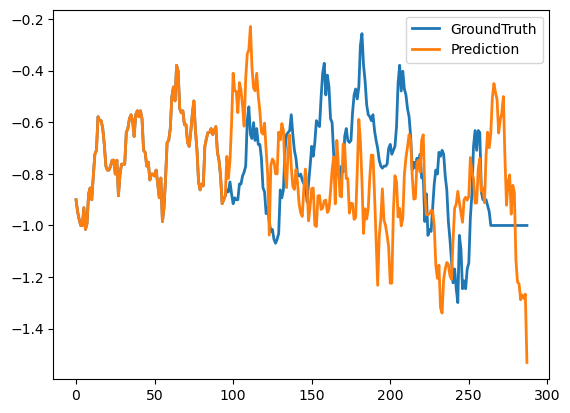

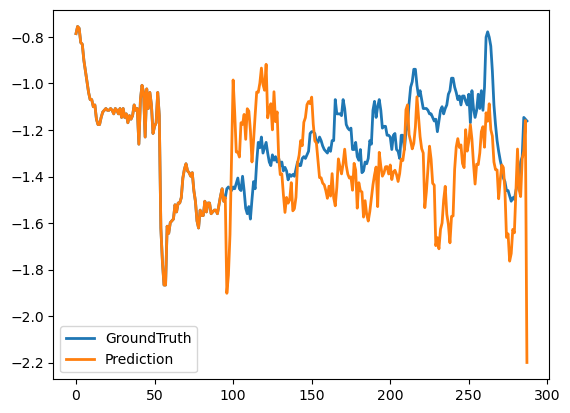

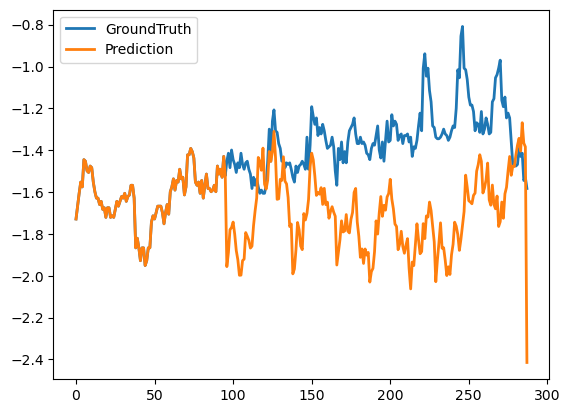

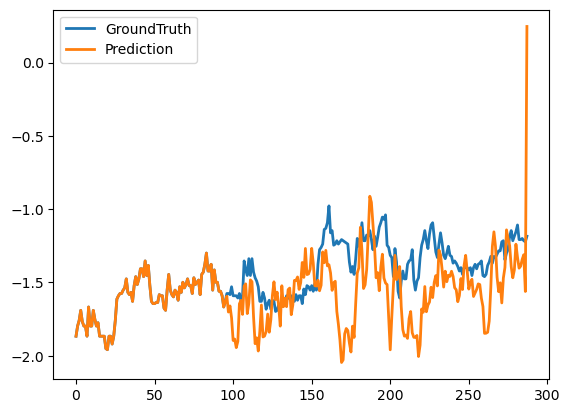

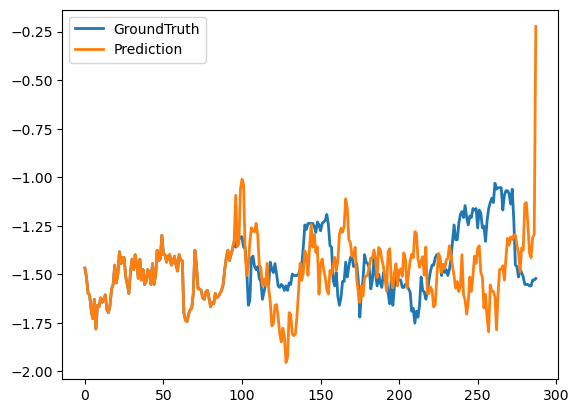

In [17]:
exp.test(setting)
torch.cuda.empty_cache()

## Trail 3: FEDFormer, Dataset:ETTh1,  Metric: 336
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [18]:
args.pred_len = 336

setting=f'{args.model}_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of FEDformer_train_on_ETTh1_336:

{'model': 'FEDformer', 'train_only': True, 'use_multi_gpu': False, 'use_gpu': True, 'learning_rate': 0.005, 'pred_len': 336, 'label_len': 48, 'seq_len': 96, 'use_amp': False, 'output_attention': False, 'features': 'M', 'checkpoints': './Checkpoints/FEDFormer_checkpoints', 'patience': 3, 'train_epochs': 6, 'data': 'ETTh1', 'root_path': './Datasets/', 'data_path': 'ETTh1.csv', 'target': 'OT', 'freq': 'h', 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'num_workers': 0, 'itr': 5, 'des': 'exp', 'gpu': 0, 'devices': '0,1,2,3', 'modes': 32, 'moving_avg': [12]}


### Training

In [19]:
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 8209
val 2545
test 2545
	iters: 100, epoch: 1 | loss: 0.4890155
	speed: 0.1541s/iter; left time: 221.4253s
	iters: 200, epoch: 1 | loss: 1.2727051
	speed: 0.1549s/iter; left time: 207.1352s
Epoch: 1 cost time: 39.30471396446228
Epoch: 1, Steps: 256 | Train Loss: 4.0886109 Vali Loss: 56.3967323 Test Loss: 61.5195541
Validation loss decreased (inf --> 56.396732).  Saving model ...
Updating learning rate to 0.005
	iters: 100, epoch: 2 | loss: 0.6539468
	speed: 0.4595s/iter; left time: 542.6645s
	iters: 200, epoch: 2 | loss: 0.6888460
	speed: 0.1579s/iter; left time: 170.6869s
Epoch: 2 cost time: 39.65671229362488
Epoch: 2, Steps: 256 | Train Loss: 2.8363526 Vali Loss: 1.5222486 Test Loss: 0.6142809
Validation loss decreased (56.396732 --> 1.522249).  Saving model ...
Updating learning rate to 0.0025
	iters: 100, epoch: 3 | loss: 0.5887660
	speed: 0.4490s/iter; left time: 415.2827s
	iters: 200, epoch: 3 | loss: 0.5724436
	speed: 0.1545s/iter; left time: 127.4907s
Epoc

Model(
  (decomp): series_decomp_multi(
    (layer): Linear(in_features=1, out_features=1, bias=True)
  )
  (enc_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (dec_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
   

test 2785


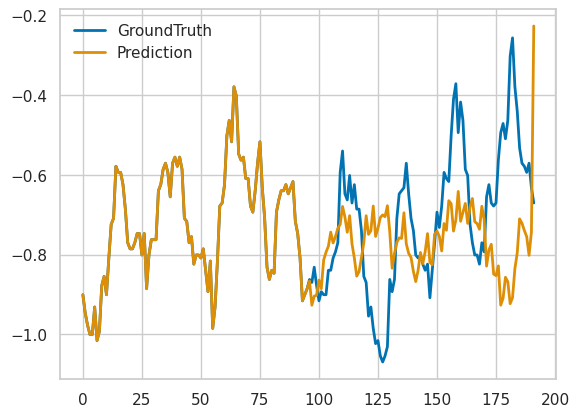

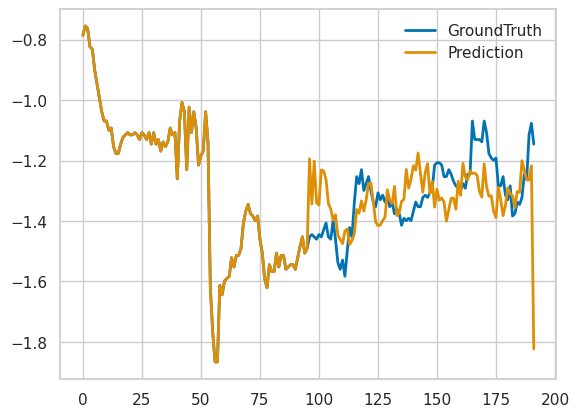

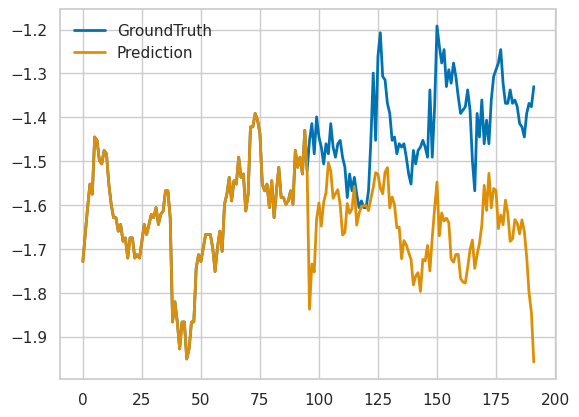

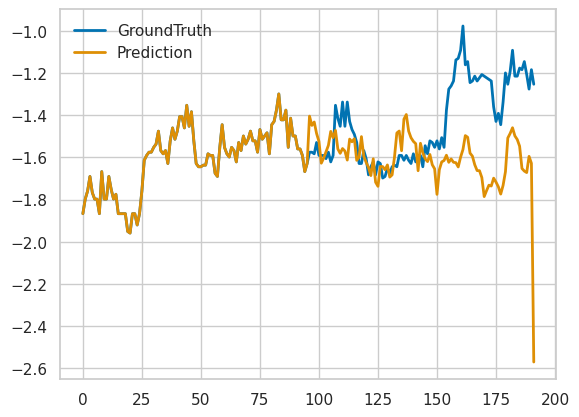


KeyboardInterrupt



In [10]:
exp.test(setting)
torch.cuda.empty_cache()

### Testing

test 2545
test shape: (79, 32, 336, 7) (79, 32, 336, 7)
test shape: (2528, 336, 7) (2528, 336, 7)
mse:0.556704580783844, mae:0.5183024406433105


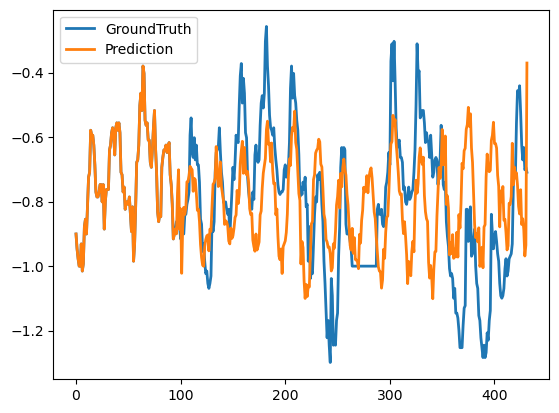

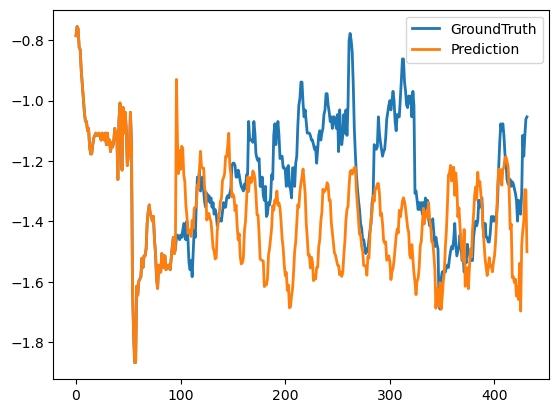

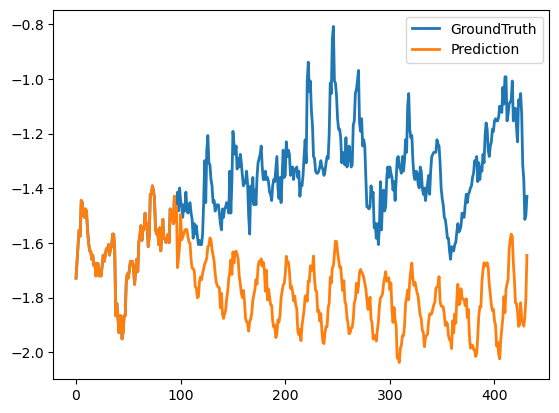

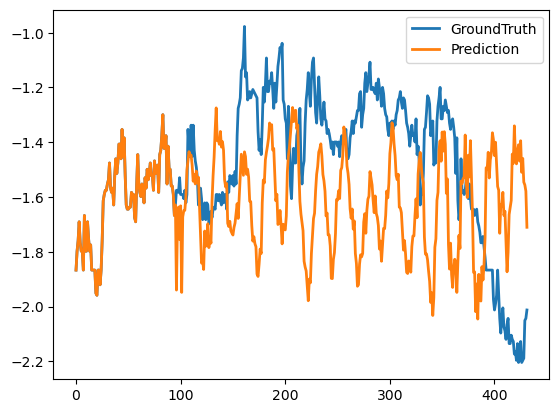

In [20]:
exp.test(setting)
torch.cuda.empty_cache()

## Trail 4: FEDFormer, Dataset:ETTh1,  Metric: 720
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [21]:
args.pred_len = 720

setting=f'{args.model}_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of FEDformer_train_on_ETTh1_720:

{'model': 'FEDformer', 'train_only': True, 'use_multi_gpu': False, 'use_gpu': True, 'learning_rate': 0.005, 'pred_len': 720, 'label_len': 48, 'seq_len': 96, 'use_amp': False, 'output_attention': False, 'features': 'M', 'checkpoints': './Checkpoints/FEDFormer_checkpoints', 'patience': 3, 'train_epochs': 6, 'data': 'ETTh1', 'root_path': './Datasets/', 'data_path': 'ETTh1.csv', 'target': 'OT', 'freq': 'h', 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'num_workers': 0, 'itr': 5, 'des': 'exp', 'gpu': 0, 'devices': '0,1,2,3', 'modes': 32, 'moving_avg': [12]}


### Training

In [22]:
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 7825
val 2161
test 2161
	iters: 100, epoch: 1 | loss: 470.3392029
	speed: 0.2206s/iter; left time: 301.0876s
	iters: 200, epoch: 1 | loss: 1.1372626
	speed: 0.2205s/iter; left time: 278.9306s
Epoch: 1 cost time: 53.777506828308105
Epoch: 1, Steps: 244 | Train Loss: 127.6394469 Vali Loss: 2.0484216 Test Loss: 0.8488290
Validation loss decreased (inf --> 2.048422).  Saving model ...
Updating learning rate to 0.005
	iters: 100, epoch: 2 | loss: 1.0326397
	speed: 0.5332s/iter; left time: 597.7022s
	iters: 200, epoch: 2 | loss: 0.8094981
	speed: 0.2230s/iter; left time: 227.6624s
Epoch: 2 cost time: 53.2063992023468
Epoch: 2, Steps: 244 | Train Loss: 0.9027460 Vali Loss: 1.9359272 Test Loss: 0.7318065
Validation loss decreased (2.048422 --> 1.935927).  Saving model ...
Updating learning rate to 0.0025
	iters: 100, epoch: 3 | loss: 0.7917534
	speed: 0.5497s/iter; left time: 482.0582s
	iters: 200, epoch: 3 | loss: 0.8311420
	speed: 0.2182s/iter; left time: 169.5656s
Epoc

Model(
  (decomp): series_decomp_multi(
    (layer): Linear(in_features=1, out_features=1, bias=True)
  )
  (enc_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (dec_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
   

### Testing

test 2161
test shape: (67, 32, 720, 7) (67, 32, 720, 7)
test shape: (2144, 720, 7) (2144, 720, 7)
mse:0.6894586086273193, mae:0.5910353660583496


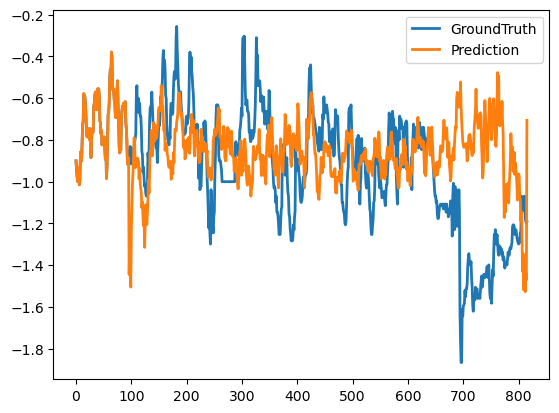

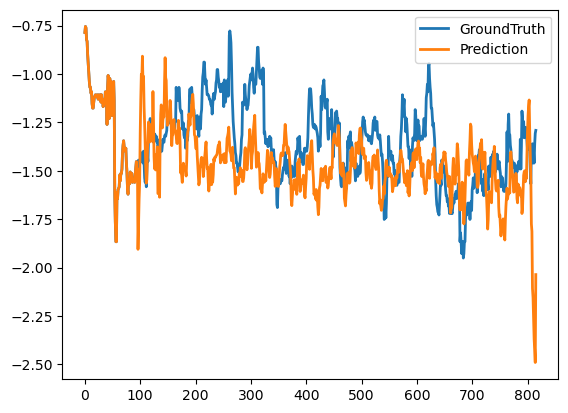

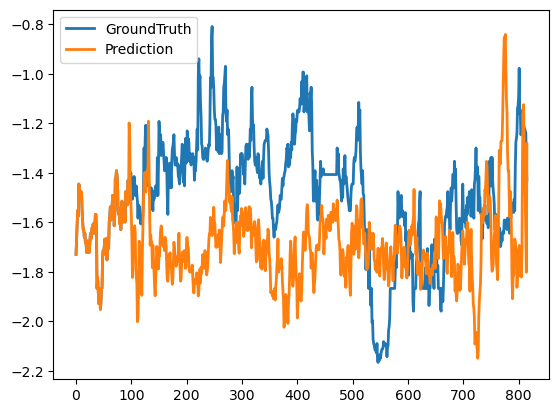

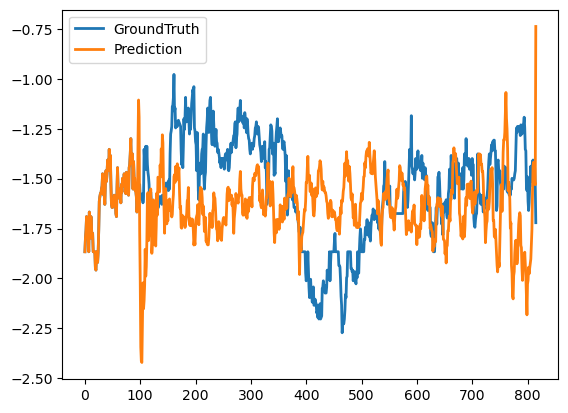

In [23]:
exp.test(setting)
torch.cuda.empty_cache()

---
# Working on ETTh2 Dataset
---

## Trail 1: FEDFormer, Dataset:ETTh2,  Metric: 96
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [46]:
args.pred_len = 96
args.data = 'ETTh2'            # dataset name
args.data_path = 'ETTh2.csv'   # data file

setting=f'{args.model}_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of FEDformer_train_on_ETTh2_96:

{'model': 'FEDformer', 'train_only': True, 'use_multi_gpu': False, 'use_gpu': True, 'learning_rate': 0.005, 'pred_len': 96, 'label_len': 48, 'seq_len': 96, 'use_amp': False, 'output_attention': False, 'features': 'M', 'checkpoints': './Checkpoints/FEDFormer_checkpoints', 'patience': 3, 'train_epochs': 6, 'data': 'ETTh2', 'root_path': './Datasets/', 'data_path': 'ETTh2.csv', 'target': 'OT', 'freq': 'h', 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'num_workers': 0, 'itr': 5, 'des': 'exp', 'gpu': 0, 'devices': '0,1,2,3', 'modes': 32, 'moving_avg': [12]}


### Training

In [47]:
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 8449
val 2785
test 2785
	iters: 100, epoch: 1 | loss: 0.4446724
	speed: 0.1040s/iter; left time: 154.3987s
	iters: 200, epoch: 1 | loss: 0.6442494
	speed: 0.1049s/iter; left time: 145.3232s
Epoch: 1 cost time: 27.632853031158447
Epoch: 1, Steps: 264 | Train Loss: 3246.6295809 Vali Loss: 333.3548279 Test Loss: 496.1320496
Validation loss decreased (inf --> 333.354828).  Saving model ...
Updating learning rate to 0.005
	iters: 100, epoch: 2 | loss: 17.5461655
	speed: 0.2118s/iter; left time: 258.5781s
	iters: 200, epoch: 2 | loss: 6.6035295
	speed: 0.1046s/iter; left time: 117.2590s
Epoch: 2 cost time: 27.60545301437378
Epoch: 2, Steps: 264 | Train Loss: 18.9588030 Vali Loss: 2.6605632 Test Loss: 3.5006578
Validation loss decreased (333.354828 --> 2.660563).  Saving model ...
Updating learning rate to 0.0025
	iters: 100, epoch: 3 | loss: 5.6767859
	speed: 0.2119s/iter; left time: 202.8188s
	iters: 200, epoch: 3 | loss: 4.9463549
	speed: 0.1033s/iter; left time: 88.5

Model(
  (decomp): series_decomp_multi(
    (layer): Linear(in_features=1, out_features=1, bias=True)
  )
  (enc_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (dec_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
   

### Testing

test 2785
test shape: (87, 32, 96, 7) (87, 32, 96, 7)
test shape: (2784, 96, 7) (2784, 96, 7)
mse:1.4281697273254395, mae:0.8705933690071106


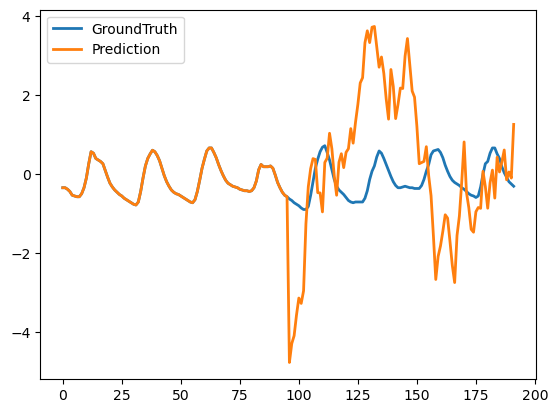

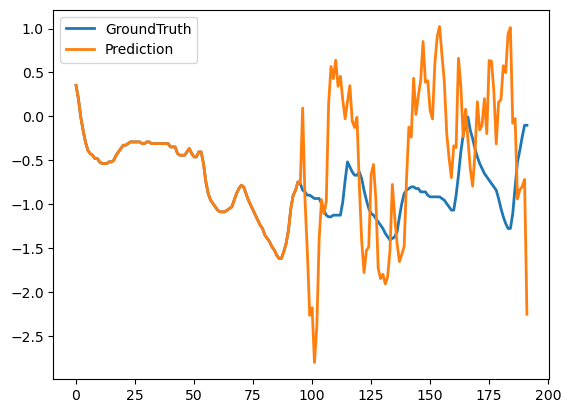

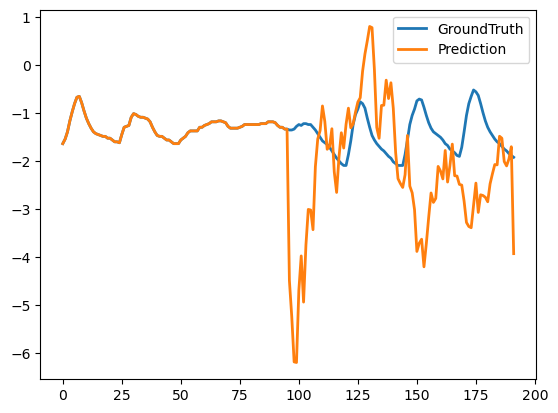

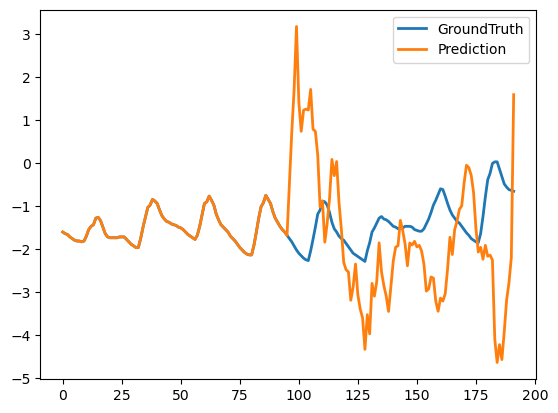

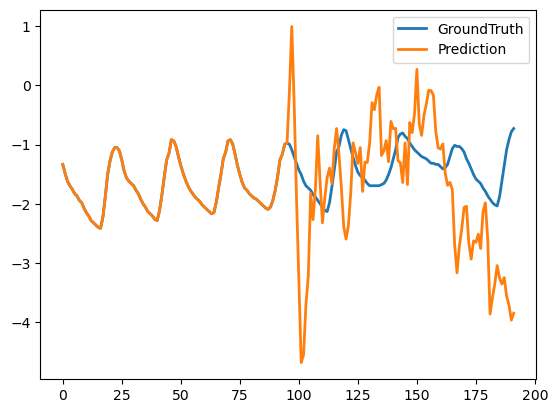

In [48]:
exp.test(setting)
torch.cuda.empty_cache()

## Trail 2: FEDFormer, Dataset:ETTh2,  Metric: 192
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [49]:
args.pred_len = 192

setting=f'{args.model}_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of FEDformer_train_on_ETTh2_192:

{'model': 'FEDformer', 'train_only': True, 'use_multi_gpu': False, 'use_gpu': True, 'learning_rate': 0.005, 'pred_len': 192, 'label_len': 48, 'seq_len': 96, 'use_amp': False, 'output_attention': False, 'features': 'M', 'checkpoints': './Checkpoints/FEDFormer_checkpoints', 'patience': 3, 'train_epochs': 6, 'data': 'ETTh2', 'root_path': './Datasets/', 'data_path': 'ETTh2.csv', 'target': 'OT', 'freq': 'h', 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'num_workers': 0, 'itr': 5, 'des': 'exp', 'gpu': 0, 'devices': '0,1,2,3', 'modes': 32, 'moving_avg': [12]}


### Training

In [50]:
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 8353
val 2689
test 2689
	iters: 100, epoch: 1 | loss: 0.6417517
	speed: 0.1240s/iter; left time: 181.8441s
	iters: 200, epoch: 1 | loss: 0.5471280
	speed: 0.1242s/iter; left time: 169.7968s
Epoch: 1 cost time: 32.4776406288147
Epoch: 1, Steps: 261 | Train Loss: 247.8957852 Vali Loss: 3199.9914551 Test Loss: 7065.9389648
Validation loss decreased (inf --> 3199.991455).  Saving model ...
Updating learning rate to 0.005
	iters: 100, epoch: 2 | loss: 1.8925285
	speed: 0.4057s/iter; left time: 489.2905s
	iters: 200, epoch: 2 | loss: 1.7254958
	speed: 0.1259s/iter; left time: 139.2254s
Epoch: 2 cost time: 32.874269008636475
Epoch: 2, Steps: 261 | Train Loss: 430.4209406 Vali Loss: 0.6645659 Test Loss: 0.9501658
Validation loss decreased (3199.991455 --> 0.664566).  Saving model ...
Updating learning rate to 0.0025
	iters: 100, epoch: 3 | loss: 1.0069617
	speed: 0.4040s/iter; left time: 381.7942s
	iters: 200, epoch: 3 | loss: 1.0988650
	speed: 0.1290s/iter; left time: 10

Model(
  (decomp): series_decomp_multi(
    (layer): Linear(in_features=1, out_features=1, bias=True)
  )
  (enc_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (dec_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
   

### Testing

test 2689
test shape: (84, 32, 192, 7) (84, 32, 192, 7)
test shape: (2688, 192, 7) (2688, 192, 7)
mse:0.7243329882621765, mae:0.6037678122520447


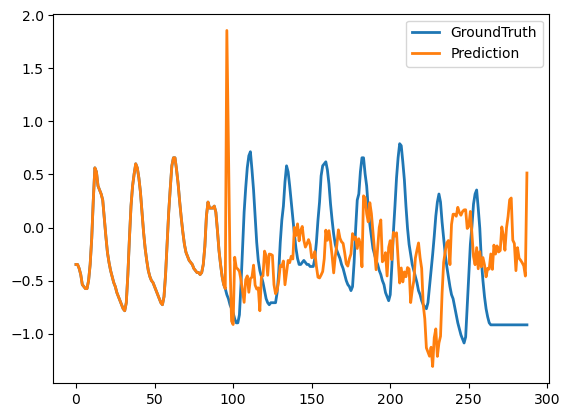

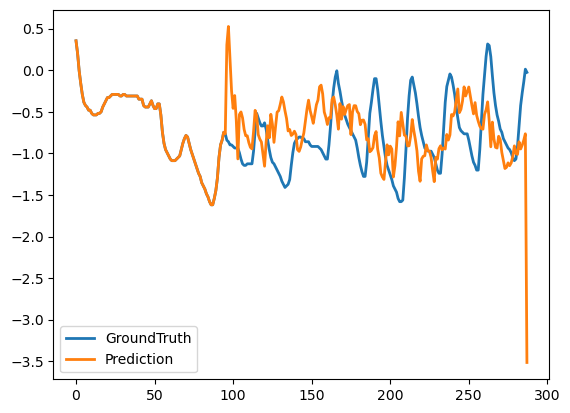

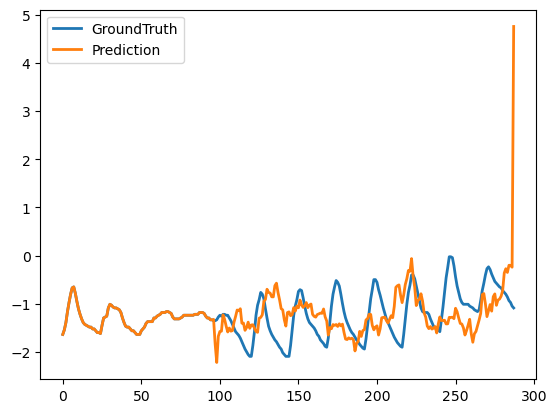

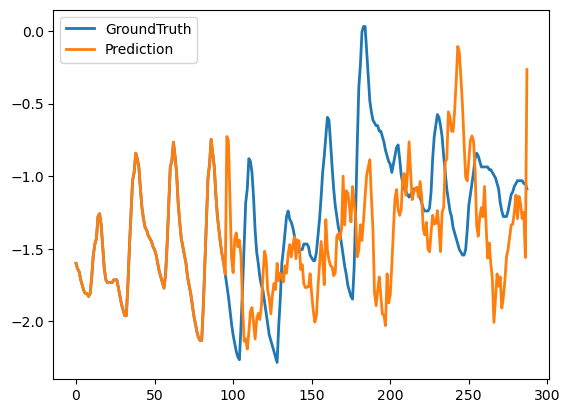

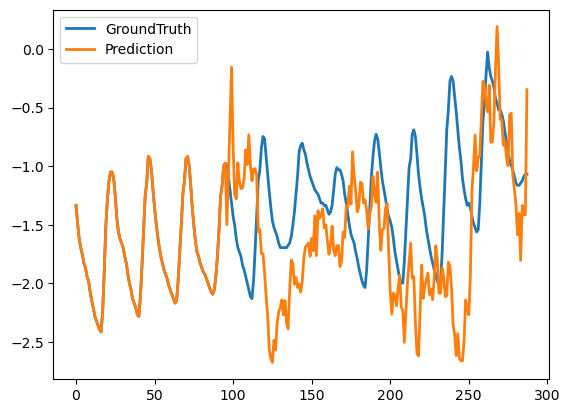

In [51]:
exp.test(setting)
torch.cuda.empty_cache()

## Trail 3: FEDFormer, Dataset:ETTh2,  Metric: 336
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [52]:
args.pred_len = 336

setting=f'{args.model}_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of FEDformer_train_on_ETTh2_336:

{'model': 'FEDformer', 'train_only': True, 'use_multi_gpu': False, 'use_gpu': True, 'learning_rate': 0.005, 'pred_len': 336, 'label_len': 48, 'seq_len': 96, 'use_amp': False, 'output_attention': False, 'features': 'M', 'checkpoints': './Checkpoints/FEDFormer_checkpoints', 'patience': 3, 'train_epochs': 6, 'data': 'ETTh2', 'root_path': './Datasets/', 'data_path': 'ETTh2.csv', 'target': 'OT', 'freq': 'h', 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'num_workers': 0, 'itr': 5, 'des': 'exp', 'gpu': 0, 'devices': '0,1,2,3', 'modes': 32, 'moving_avg': [12]}


### Training

In [53]:
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 8209
val 2545
test 2545
	iters: 100, epoch: 1 | loss: 0.3069273
	speed: 0.1510s/iter; left time: 216.9450s
	iters: 200, epoch: 1 | loss: 0.9880660
	speed: 0.1521s/iter; left time: 203.3049s
Epoch: 1 cost time: 38.77499580383301
Epoch: 1, Steps: 256 | Train Loss: 26.4885322 Vali Loss: 0.4640145 Test Loss: 0.5191075
Validation loss decreased (inf --> 0.464014).  Saving model ...
Updating learning rate to 0.005
	iters: 100, epoch: 2 | loss: 9.7098894
	speed: 0.4550s/iter; left time: 537.3438s
	iters: 200, epoch: 2 | loss: 0.7593350
	speed: 0.1510s/iter; left time: 163.2166s
Epoch: 2 cost time: 38.35886335372925
Epoch: 2, Steps: 256 | Train Loss: 175385.2084749 Vali Loss: 15600.2548828 Test Loss: 50470.6250000
EarlyStopping counter: 1 out of 3
Updating learning rate to 0.0025
	iters: 100, epoch: 3 | loss: 467.2163086
	speed: 0.4434s/iter; left time: 410.1363s
	iters: 200, epoch: 3 | loss: 210.8549042
	speed: 0.1520s/iter; left time: 125.4012s
Epoch: 3 cost time: 39.12

Model(
  (decomp): series_decomp_multi(
    (layer): Linear(in_features=1, out_features=1, bias=True)
  )
  (enc_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (dec_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
   

### Testing

test 2545
test shape: (79, 32, 336, 7) (79, 32, 336, 7)
test shape: (2528, 336, 7) (2528, 336, 7)
mse:0.5191075801849365, mae:0.5140064358711243


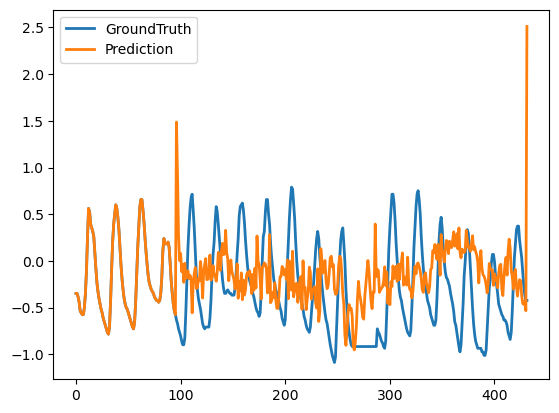

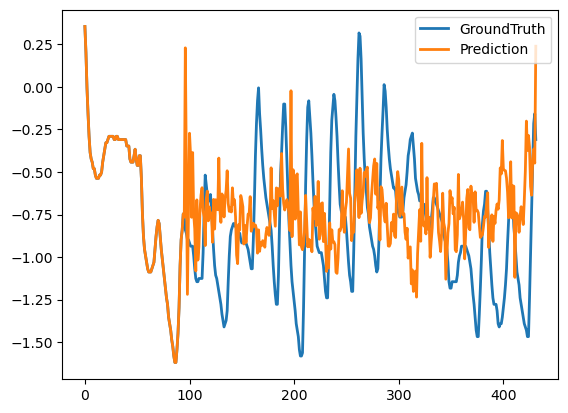

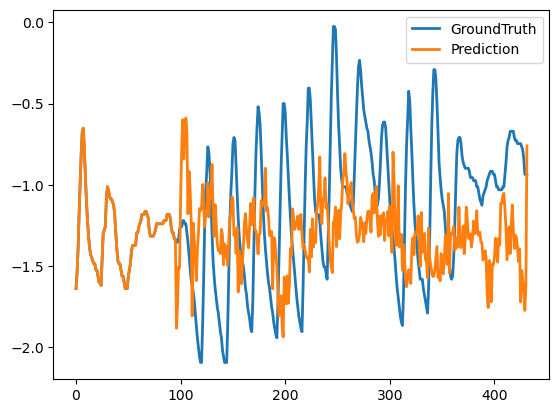

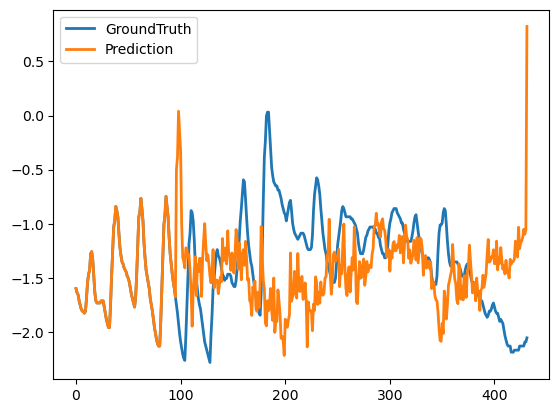

In [54]:
exp.test(setting)
torch.cuda.empty_cache()

## Trail 4: FEDFormer, Dataset:ETTh2,  Metric: 720
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [10]:
args.pred_len = 720

setting=f'{args.model}_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of FEDformer_train_on_ETTh2_720:

{'model': 'FEDformer', 'train_only': True, 'use_multi_gpu': False, 'use_gpu': True, 'learning_rate': 0.005, 'pred_len': 720, 'label_len': 48, 'seq_len': 96, 'use_amp': False, 'output_attention': False, 'features': 'M', 'checkpoints': './Checkpoints/FEDFormer_checkpoints', 'patience': 3, 'train_epochs': 6, 'data': 'ETTh2', 'root_path': './Datasets/', 'data_path': 'ETTh1.csv', 'target': 'OT', 'freq': 'h', 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'num_workers': 0, 'itr': 5, 'des': 'exp', 'gpu': 0, 'devices': '0,1,2,3', 'modes': 32, 'moving_avg': [12]}


### Training

In [13]:
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 7825
val 2161
test 2161
	iters: 100, epoch: 1 | loss: 0.6076492
	speed: 0.2303s/iter; left time: 314.3937s
	iters: 200, epoch: 1 | loss: 0.6588693
	speed: 0.2156s/iter; left time: 272.7362s
Epoch: 1 cost time: 54.11409044265747
Epoch: 1, Steps: 244 | Train Loss: 736.4909483 Vali Loss: 665.3992920 Test Loss: 748.9404907
Validation loss decreased (inf --> 665.399292).  Saving model ...
Updating learning rate to 0.005
	iters: 100, epoch: 2 | loss: 4.2726688
	speed: 0.5302s/iter; left time: 594.3437s
	iters: 200, epoch: 2 | loss: 3.1538663
	speed: 0.2185s/iter; left time: 223.1100s
Epoch: 2 cost time: 52.55988359451294
Epoch: 2, Steps: 244 | Train Loss: 24.3215806 Vali Loss: 2.6582723 Test Loss: 1.6666837
Validation loss decreased (665.399292 --> 2.658272).  Saving model ...
Updating learning rate to 0.0025
	iters: 100, epoch: 3 | loss: 2.0890498
	speed: 0.5227s/iter; left time: 458.3908s
	iters: 200, epoch: 3 | loss: 1.7449480
	speed: 0.2156s/iter; left time: 167.522

Model(
  (decomp): series_decomp_multi(
    (layer): Linear(in_features=1, out_features=1, bias=True)
  )
  (enc_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (dec_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
   

### Testing

test 2161
test shape: (67, 32, 720, 7) (67, 32, 720, 7)
test shape: (2144, 720, 7) (2144, 720, 7)
mse:1.0289963483810425, mae:0.7359339594841003


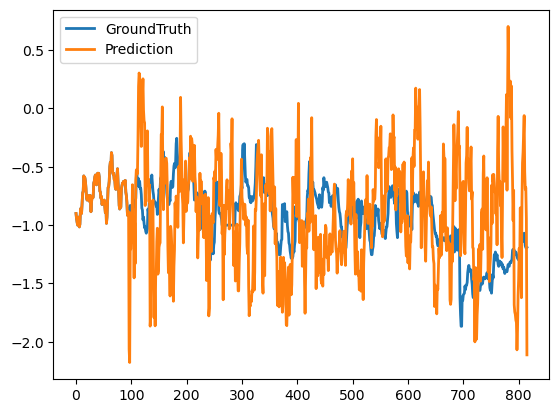

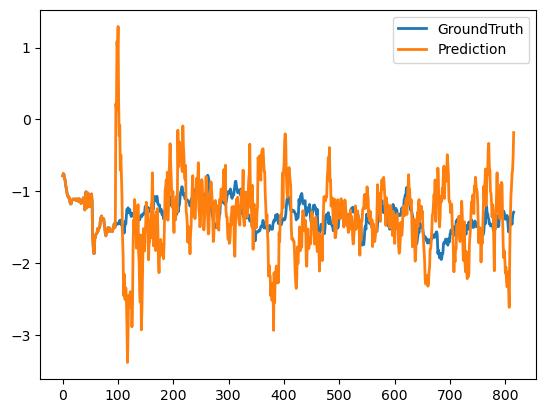

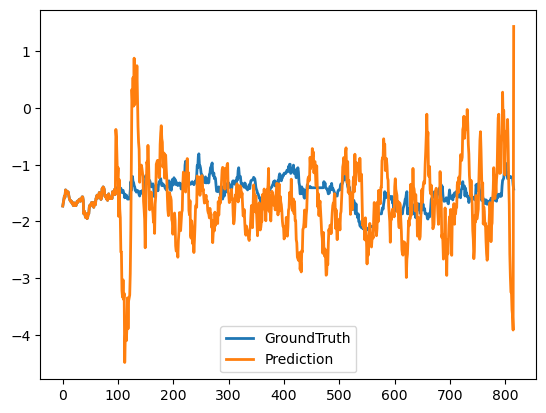

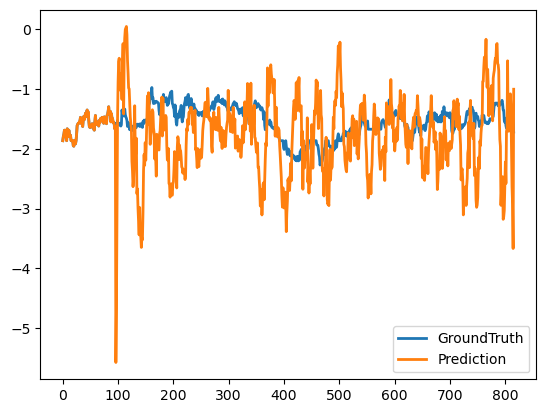

In [14]:
exp.test(setting)
torch.cuda.empty_cache()

---
# Working on ETTm1 Dataset
---

## Trail 1: FEDFormer, Dataset:ETTm1,  Metric: 96
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [15]:
args.pred_len = 96
args.data = 'ETTm1'            # dataset name
args.data_path = 'ETTm1.csv'   # data file

setting=f'{args.model}_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of FEDformer_train_on_ETTm1_96:

{'model': 'FEDformer', 'train_only': True, 'use_multi_gpu': False, 'use_gpu': True, 'learning_rate': 0.005, 'pred_len': 96, 'label_len': 48, 'seq_len': 96, 'use_amp': False, 'output_attention': False, 'features': 'M', 'checkpoints': './Checkpoints/FEDFormer_checkpoints', 'patience': 3, 'train_epochs': 6, 'data': 'ETTm1', 'root_path': './Datasets/', 'data_path': 'ETTm1.csv', 'target': 'OT', 'freq': 'h', 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'num_workers': 0, 'itr': 5, 'des': 'exp', 'gpu': 0, 'devices': '0,1,2,3', 'modes': 32, 'moving_avg': [12]}


### Training

In [16]:
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 34369
val 11425
test 11425
	iters: 100, epoch: 1 | loss: 0.3476372
	speed: 0.1003s/iter; left time: 636.6521s
	iters: 200, epoch: 1 | loss: 3895.9531250
	speed: 0.1008s/iter; left time: 629.3936s
	iters: 300, epoch: 1 | loss: 167.8199158
	speed: 0.1001s/iter; left time: 614.9018s
	iters: 400, epoch: 1 | loss: 106.8775864
	speed: 0.1000s/iter; left time: 604.5056s
	iters: 500, epoch: 1 | loss: 96.4726334
	speed: 0.1000s/iter; left time: 594.6108s
	iters: 600, epoch: 1 | loss: 105.4660645
	speed: 0.1001s/iter; left time: 585.3415s
	iters: 700, epoch: 1 | loss: 74.7034836
	speed: 0.1001s/iter; left time: 575.2040s
	iters: 800, epoch: 1 | loss: 110.0791702
	speed: 0.1005s/iter; left time: 567.4704s
	iters: 900, epoch: 1 | loss: 78.1142273
	speed: 0.1015s/iter; left time: 562.5551s
	iters: 1000, epoch: 1 | loss: 73.2131577
	speed: 0.1017s/iter; left time: 553.7984s
Epoch: 1 cost time: 108.07164287567139
Epoch: 1, Steps: 1074 | Train Loss: 21456.6368467 Vali Loss: 15.70

Model(
  (decomp): series_decomp_multi(
    (layer): Linear(in_features=1, out_features=1, bias=True)
  )
  (enc_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (dec_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
   

### Testing

test 11425
test shape: (357, 32, 96, 7) (357, 32, 96, 7)
test shape: (11424, 96, 7) (11424, 96, 7)
mse:2.199519395828247, mae:1.1190853118896484


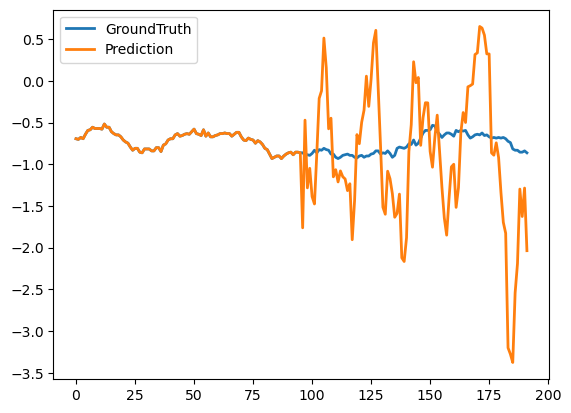

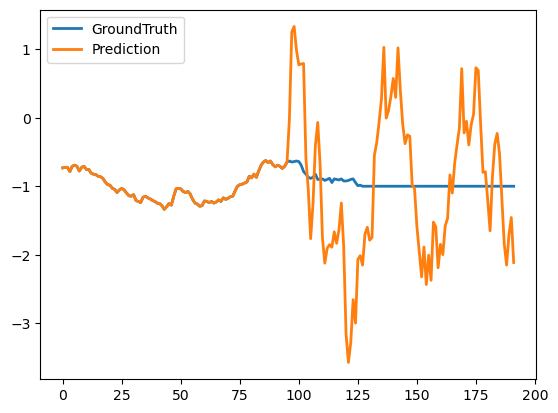

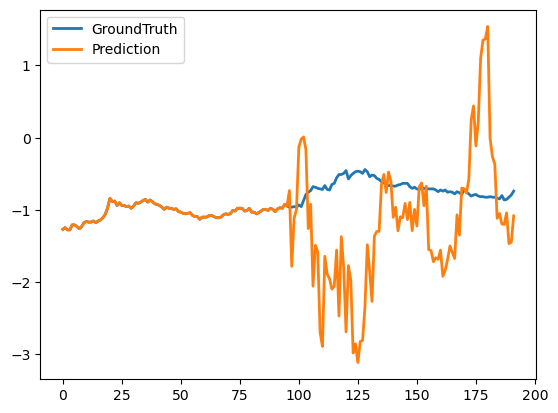

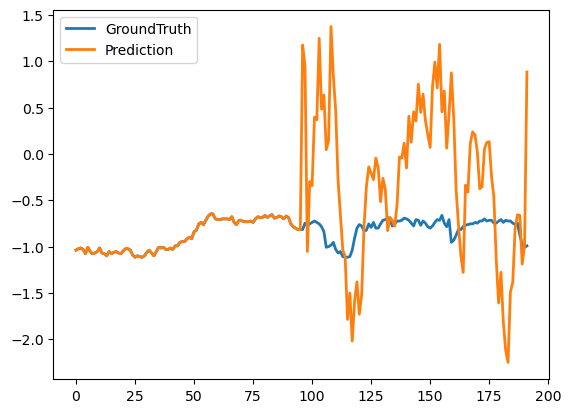

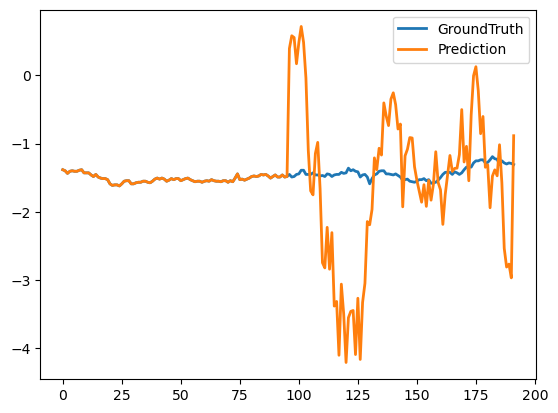

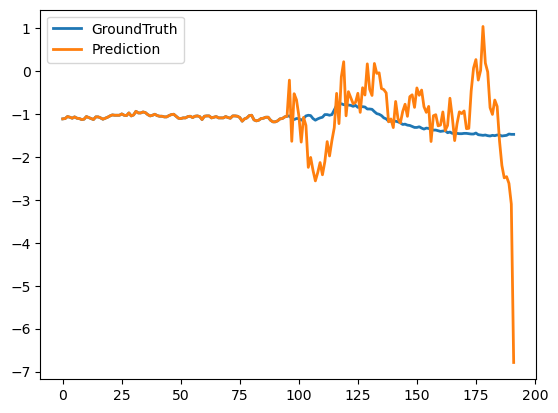

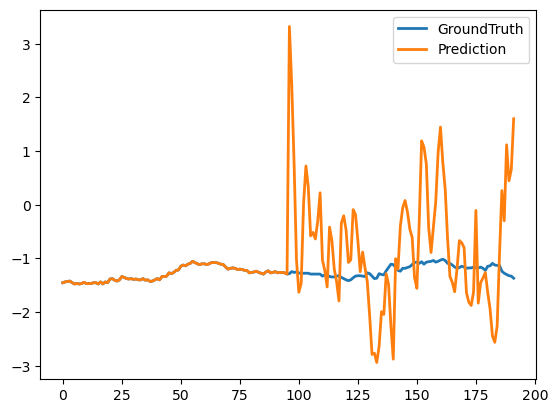

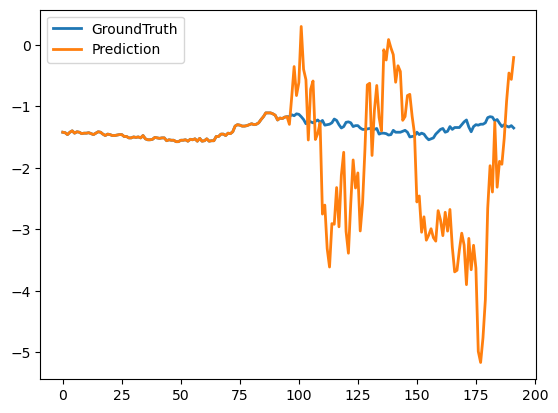

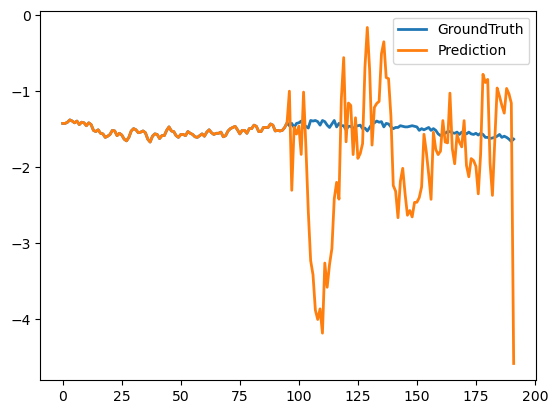

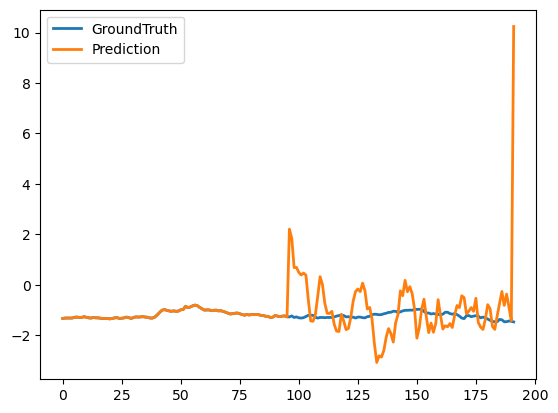

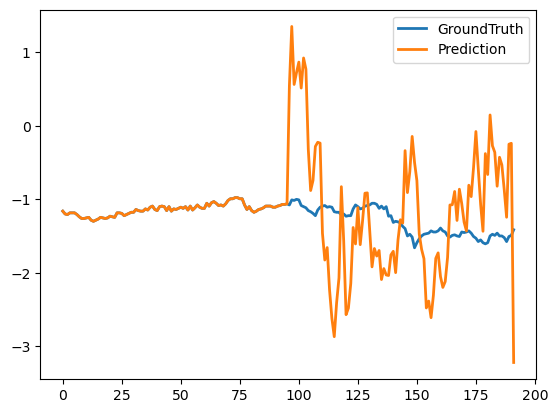

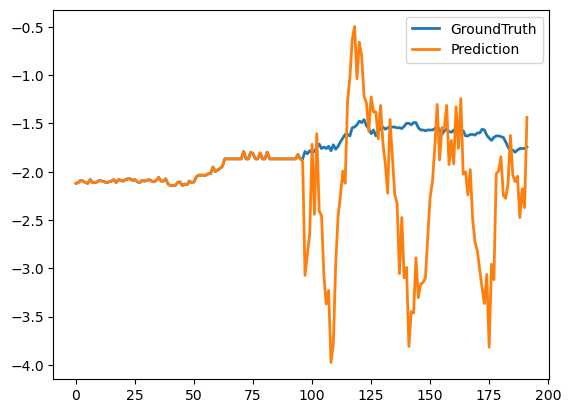

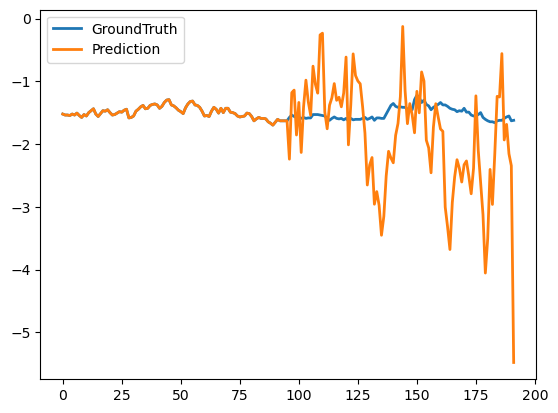

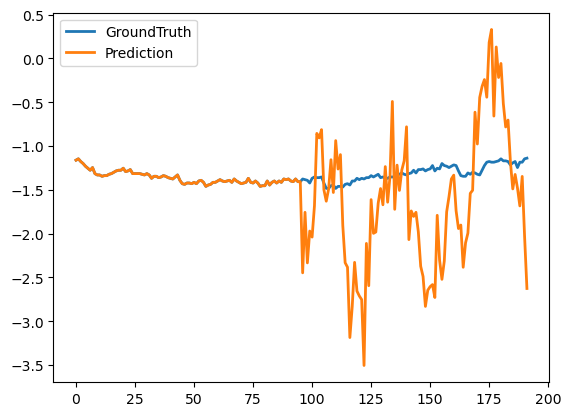

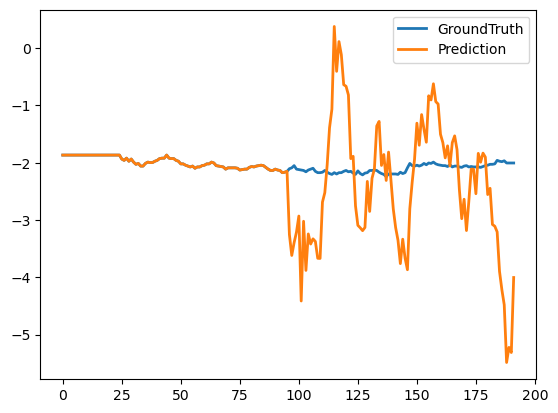

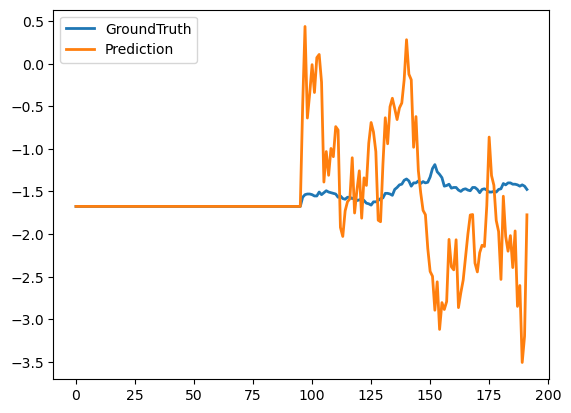

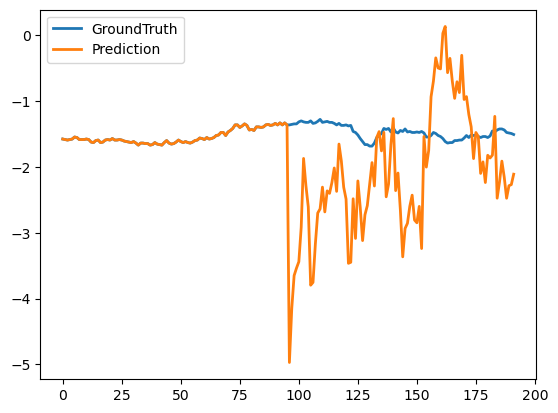

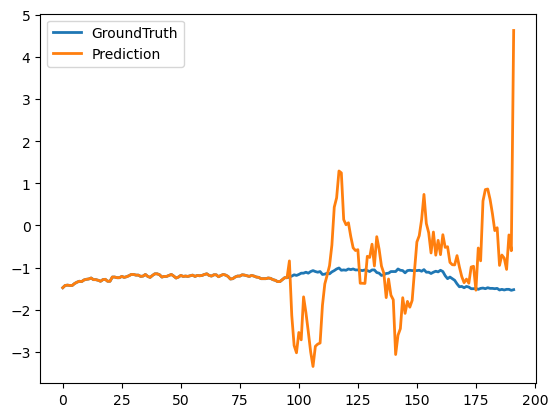

In [17]:
exp.test(setting)
torch.cuda.empty_cache()

## Trail 2: FEDFormer, Dataset:ETTm1,  Metric: 192
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [18]:
args.pred_len = 192

setting=f'{args.model}_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of FEDformer_train_on_ETTm1_192:

{'model': 'FEDformer', 'train_only': True, 'use_multi_gpu': False, 'use_gpu': True, 'learning_rate': 0.005, 'pred_len': 192, 'label_len': 48, 'seq_len': 96, 'use_amp': False, 'output_attention': False, 'features': 'M', 'checkpoints': './Checkpoints/FEDFormer_checkpoints', 'patience': 3, 'train_epochs': 6, 'data': 'ETTm1', 'root_path': './Datasets/', 'data_path': 'ETTm1.csv', 'target': 'OT', 'freq': 'h', 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'num_workers': 0, 'itr': 5, 'des': 'exp', 'gpu': 0, 'devices': '0,1,2,3', 'modes': 32, 'moving_avg': [12]}


### Training

In [19]:
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 34273
val 11329
test 11329
	iters: 100, epoch: 1 | loss: 164.3631744
	speed: 0.1206s/iter; left time: 763.3168s
	iters: 200, epoch: 1 | loss: 1.4168357
	speed: 0.1260s/iter; left time: 784.5986s
	iters: 300, epoch: 1 | loss: 0.8929861
	speed: 0.1219s/iter; left time: 747.0866s
	iters: 400, epoch: 1 | loss: 0.8532379
	speed: 0.1243s/iter; left time: 749.2838s
	iters: 500, epoch: 1 | loss: 0.6178181
	speed: 0.1230s/iter; left time: 728.8307s
	iters: 600, epoch: 1 | loss: 0.6239780
	speed: 0.1227s/iter; left time: 715.0186s
	iters: 700, epoch: 1 | loss: 0.5531533
	speed: 0.1251s/iter; left time: 716.5910s
	iters: 800, epoch: 1 | loss: 0.6392283
	speed: 0.1246s/iter; left time: 701.0476s
	iters: 900, epoch: 1 | loss: 0.5593863
	speed: 0.1233s/iter; left time: 681.6825s
	iters: 1000, epoch: 1 | loss: 0.4530951
	speed: 0.1240s/iter; left time: 672.7325s
Epoch: 1 cost time: 132.4200406074524
Epoch: 1, Steps: 1071 | Train Loss: 60.3044016 Vali Loss: 0.8490469 Test Loss: 0

Model(
  (decomp): series_decomp_multi(
    (layer): Linear(in_features=1, out_features=1, bias=True)
  )
  (enc_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (dec_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
   

### Testing

test 11329
test shape: (354, 32, 192, 7) (354, 32, 192, 7)
test shape: (11328, 192, 7) (11328, 192, 7)
mse:0.6836256980895996, mae:0.5567268133163452


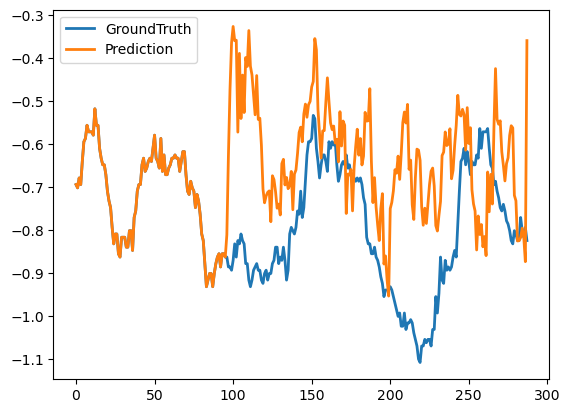

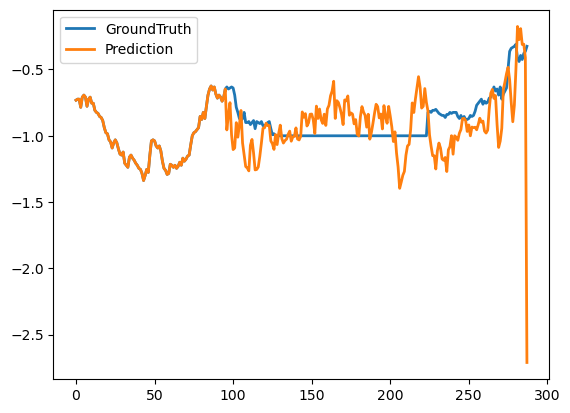

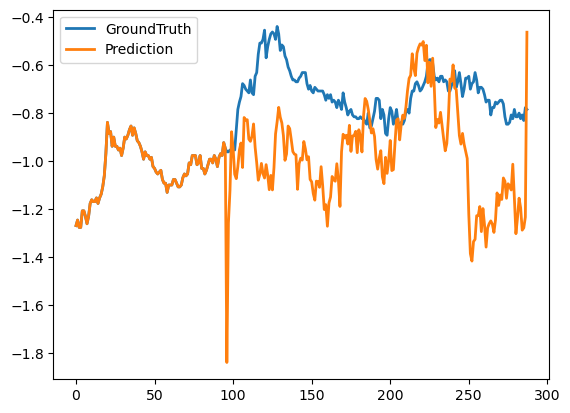

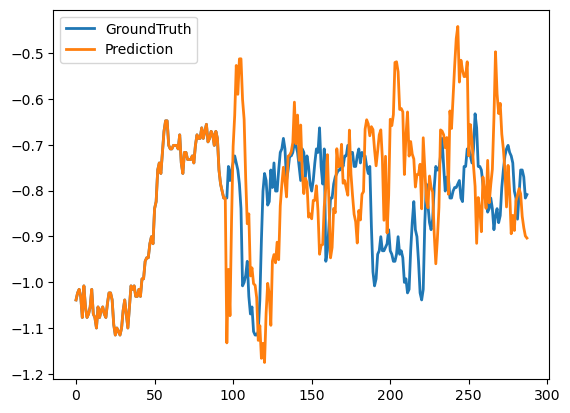

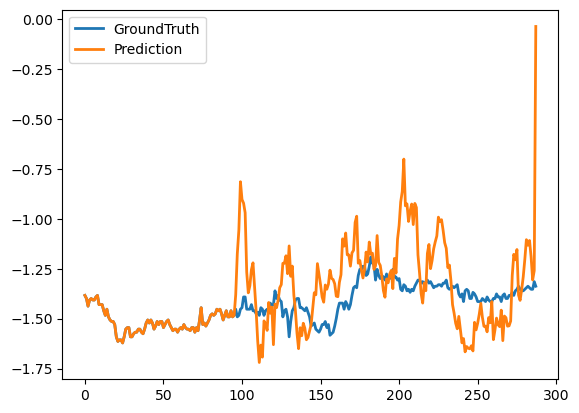

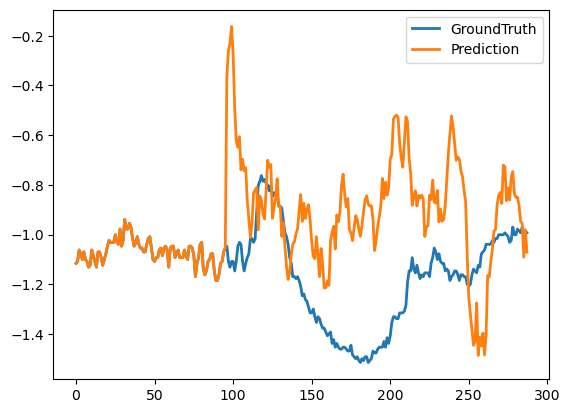

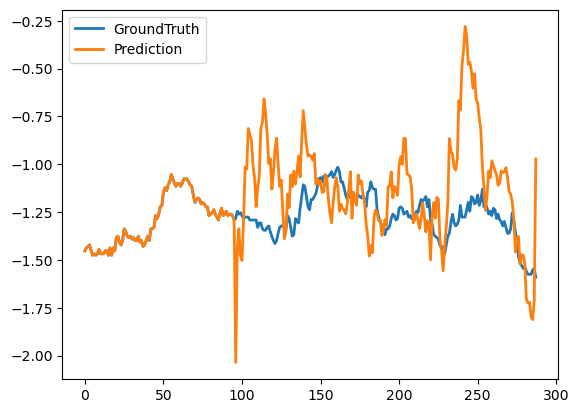

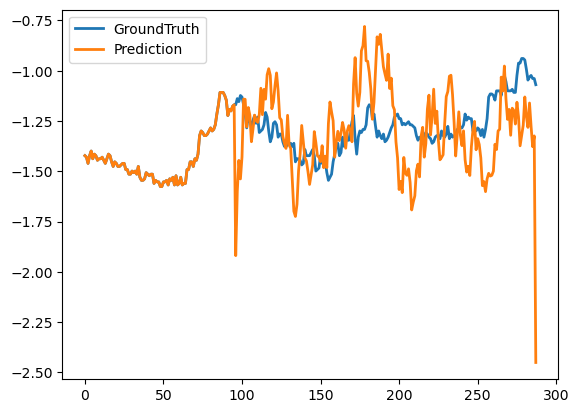

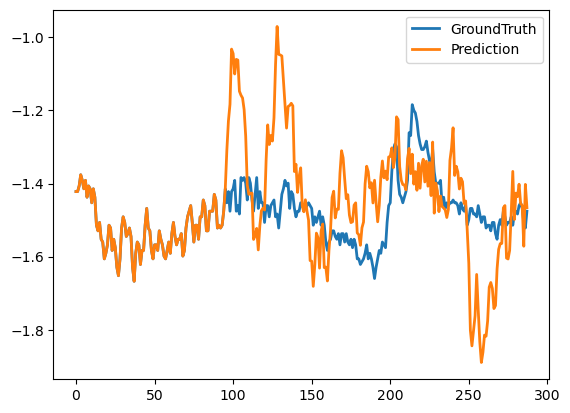

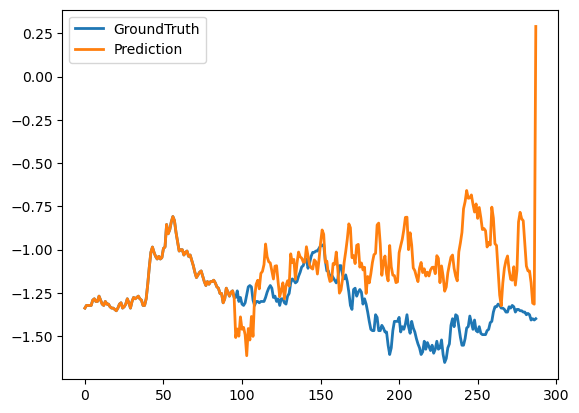

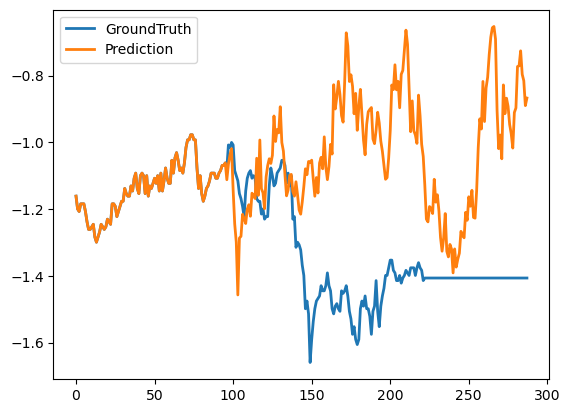

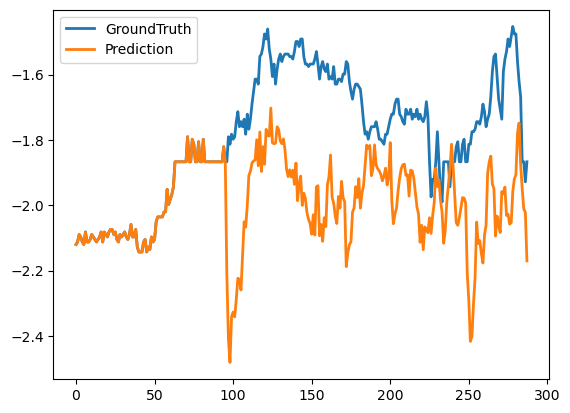

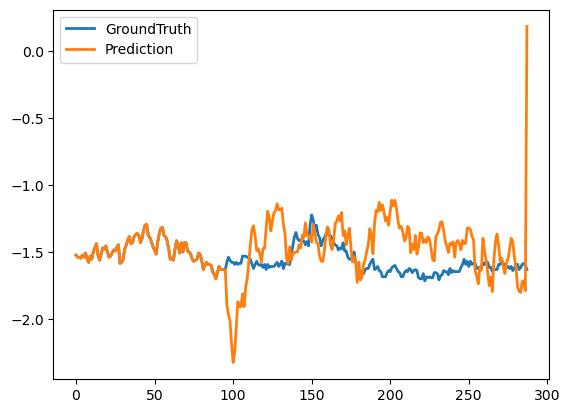

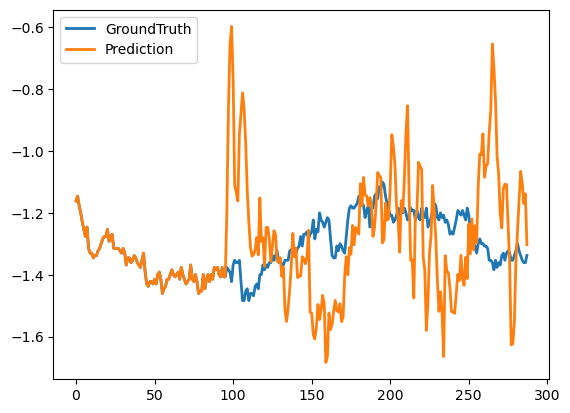

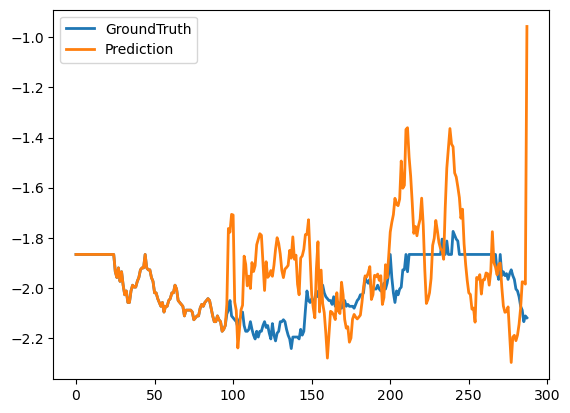

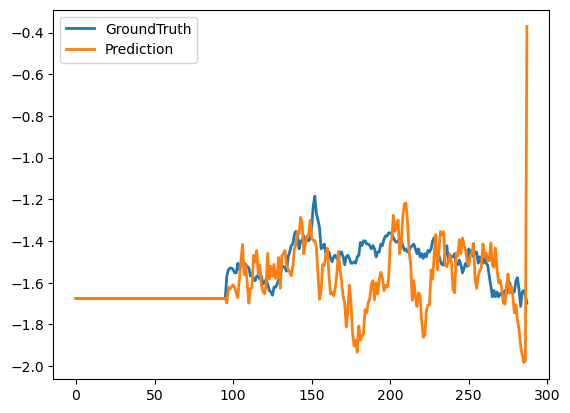

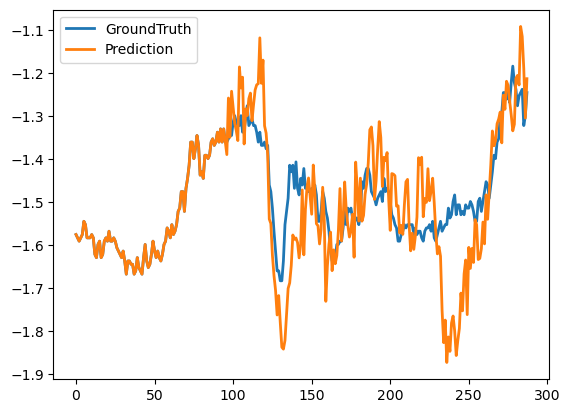

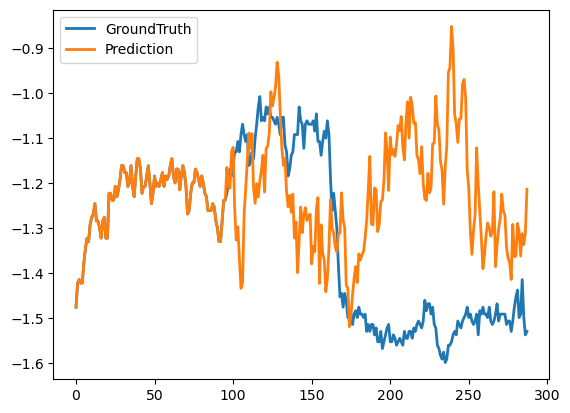

In [20]:
exp.test(setting)
torch.cuda.empty_cache()

## Trail 3: FEDFormer, Dataset:ETTm1,  Metric: 336
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [21]:
args.pred_len = 336

setting=f'{args.model}_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of FEDformer_train_on_ETTm1_336:

{'model': 'FEDformer', 'train_only': True, 'use_multi_gpu': False, 'use_gpu': True, 'learning_rate': 0.005, 'pred_len': 336, 'label_len': 48, 'seq_len': 96, 'use_amp': False, 'output_attention': False, 'features': 'M', 'checkpoints': './Checkpoints/FEDFormer_checkpoints', 'patience': 3, 'train_epochs': 6, 'data': 'ETTm1', 'root_path': './Datasets/', 'data_path': 'ETTm1.csv', 'target': 'OT', 'freq': 'h', 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'num_workers': 0, 'itr': 5, 'des': 'exp', 'gpu': 0, 'devices': '0,1,2,3', 'modes': 32, 'moving_avg': [12]}


### Training

In [22]:
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 34129
val 11185
test 11185
	iters: 100, epoch: 1 | loss: 0.4197087
	speed: 0.1501s/iter; left time: 945.2374s
	iters: 200, epoch: 1 | loss: 0.4829959
	speed: 0.1496s/iter; left time: 927.1223s
	iters: 300, epoch: 1 | loss: 0.4832256
	speed: 0.1485s/iter; left time: 905.3992s
	iters: 400, epoch: 1 | loss: 9403.5898438
	speed: 0.1467s/iter; left time: 880.0566s
	iters: 500, epoch: 1 | loss: 528.7283325
	speed: 0.1493s/iter; left time: 880.4319s
	iters: 600, epoch: 1 | loss: 313.3174438
	speed: 0.1503s/iter; left time: 871.1172s
	iters: 700, epoch: 1 | loss: 233.9052582
	speed: 0.1511s/iter; left time: 861.0516s
	iters: 800, epoch: 1 | loss: 104.8648529
	speed: 0.1496s/iter; left time: 837.3631s
	iters: 900, epoch: 1 | loss: 103.2808380
	speed: 0.1504s/iter; left time: 826.6682s
	iters: 1000, epoch: 1 | loss: 82.0840759
	speed: 0.1514s/iter; left time: 817.3535s
Epoch: 1 cost time: 159.79857730865479
Epoch: 1, Steps: 1066 | Train Loss: 22859.1782325 Vali Loss: 21.638

Model(
  (decomp): series_decomp_multi(
    (layer): Linear(in_features=1, out_features=1, bias=True)
  )
  (enc_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (dec_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
   

### Testing

test 11185
test shape: (349, 32, 336, 7) (349, 32, 336, 7)
test shape: (11168, 336, 7) (11168, 336, 7)
mse:24.198532104492188, mae:3.42040753364563


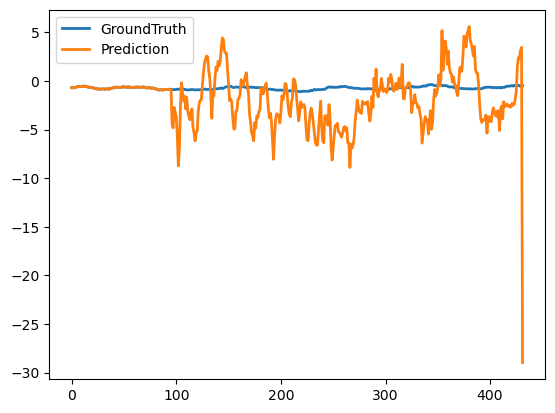

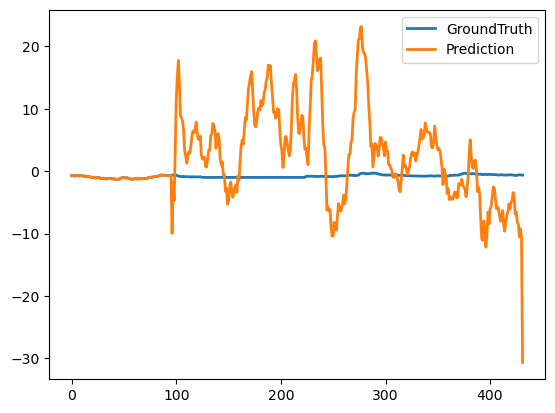

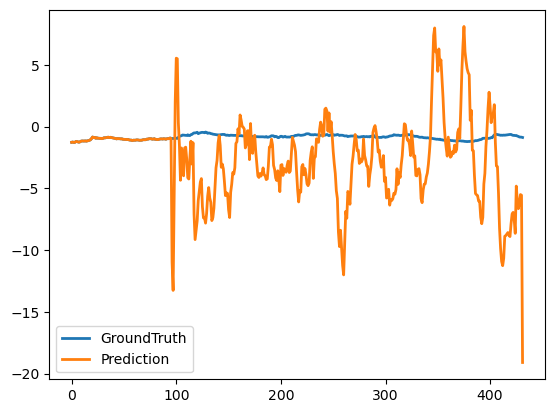

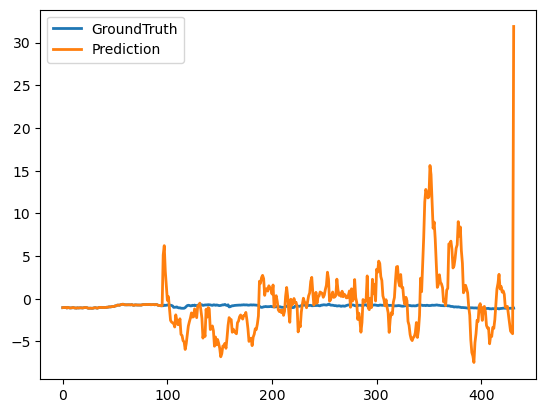

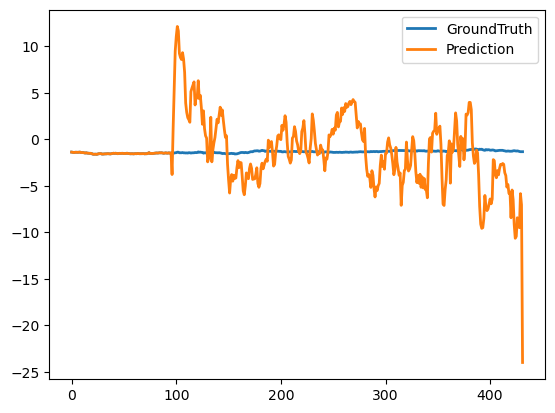

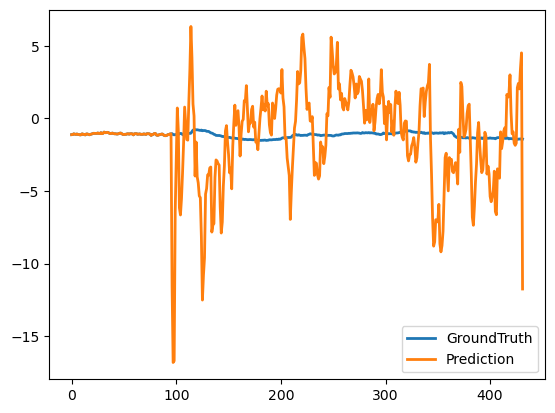

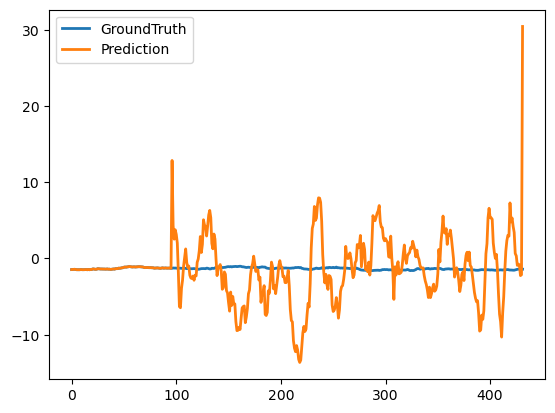

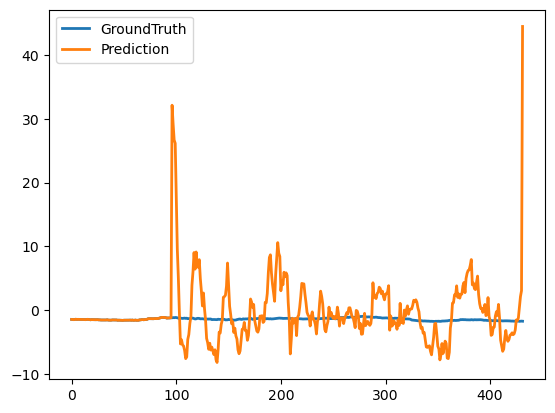

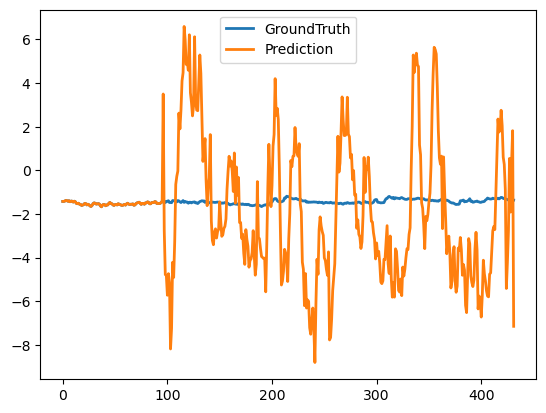

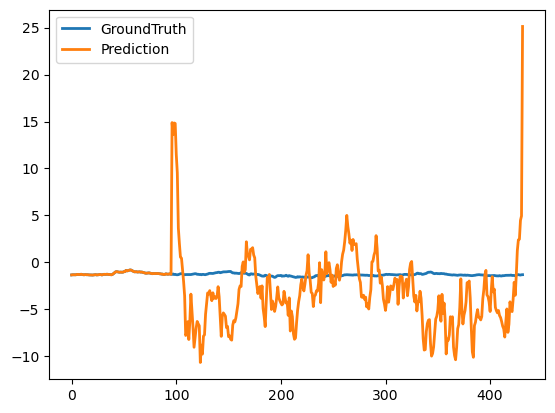

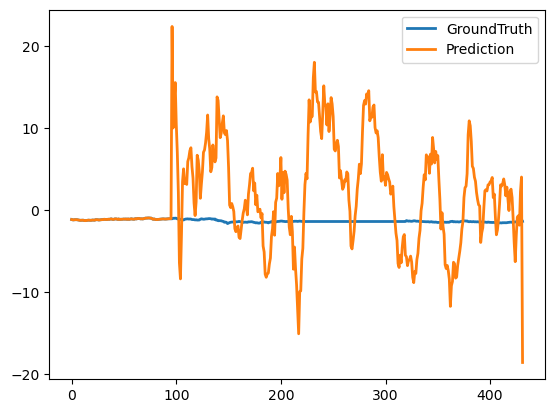

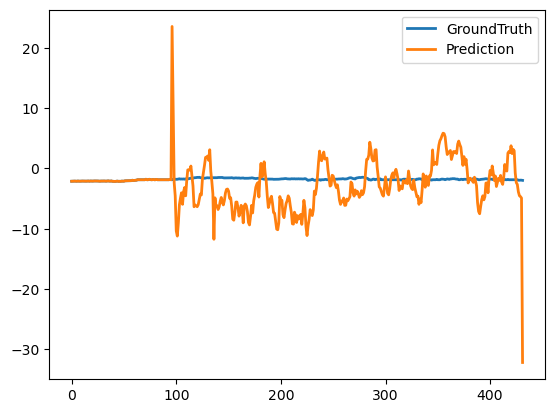

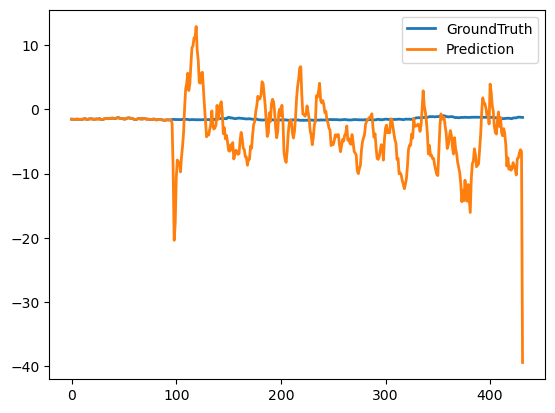

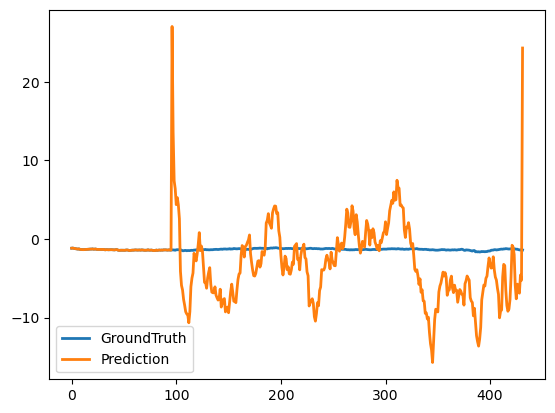

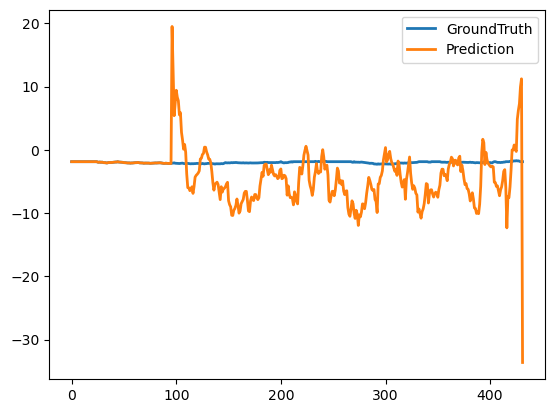

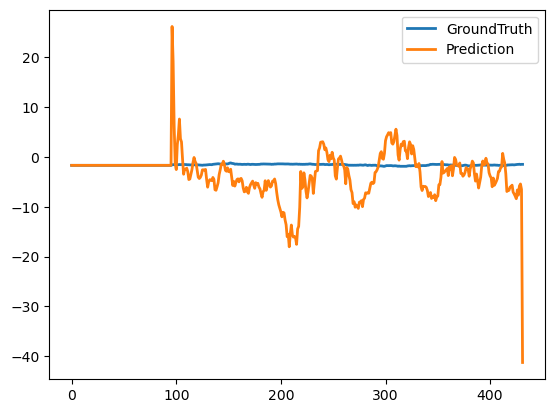

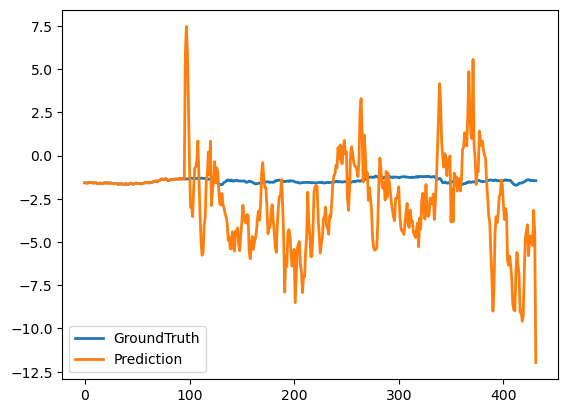

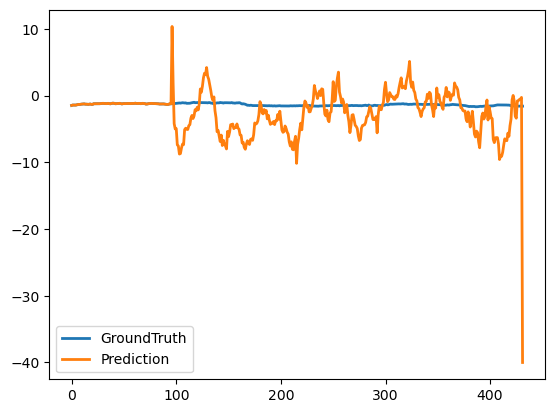

In [23]:
exp.test(setting)
torch.cuda.empty_cache()

## Trail 4: FEDFormer, Dataset:ETTm1,  Metric: 720
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [24]:
args.pred_len = 720

setting=f'{args.model}_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of FEDformer_train_on_ETTm1_720:

{'model': 'FEDformer', 'train_only': True, 'use_multi_gpu': False, 'use_gpu': True, 'learning_rate': 0.005, 'pred_len': 720, 'label_len': 48, 'seq_len': 96, 'use_amp': False, 'output_attention': False, 'features': 'M', 'checkpoints': './Checkpoints/FEDFormer_checkpoints', 'patience': 3, 'train_epochs': 6, 'data': 'ETTm1', 'root_path': './Datasets/', 'data_path': 'ETTm1.csv', 'target': 'OT', 'freq': 'h', 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'num_workers': 0, 'itr': 5, 'des': 'exp', 'gpu': 0, 'devices': '0,1,2,3', 'modes': 32, 'moving_avg': [12]}


### Training

In [25]:
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 33745
val 10801
test 10801
	iters: 100, epoch: 1 | loss: 0.7549630
	speed: 0.2122s/iter; left time: 1320.8663s
	iters: 200, epoch: 1 | loss: 0.8247113
	speed: 0.2181s/iter; left time: 1336.1245s
	iters: 300, epoch: 1 | loss: 0.7046751
	speed: 0.2180s/iter; left time: 1313.4941s
	iters: 400, epoch: 1 | loss: 0.7526156
	speed: 0.2158s/iter; left time: 1278.5762s
	iters: 500, epoch: 1 | loss: 0.7465989
	speed: 0.2203s/iter; left time: 1283.0219s
	iters: 600, epoch: 1 | loss: 0.5709481
	speed: 0.2175s/iter; left time: 1245.1857s
	iters: 700, epoch: 1 | loss: 0.5623637
	speed: 0.2210s/iter; left time: 1243.3241s
	iters: 800, epoch: 1 | loss: 0.6713542
	speed: 0.2196s/iter; left time: 1213.3804s
	iters: 900, epoch: 1 | loss: 0.5563511
	speed: 0.2148s/iter; left time: 1165.5186s
	iters: 1000, epoch: 1 | loss: 0.5729132
	speed: 0.2182s/iter; left time: 1161.7472s
Epoch: 1 cost time: 229.5204255580902
Epoch: 1, Steps: 1054 | Train Loss: 25.1805501 Vali Loss: 1.2340903 Test

Model(
  (decomp): series_decomp_multi(
    (layer): Linear(in_features=1, out_features=1, bias=True)
  )
  (enc_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (dec_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
   

### Testing

test 10801
test shape: (337, 32, 720, 7) (337, 32, 720, 7)
test shape: (10784, 720, 7) (10784, 720, 7)
mse:0.7006668448448181, mae:0.5717172622680664


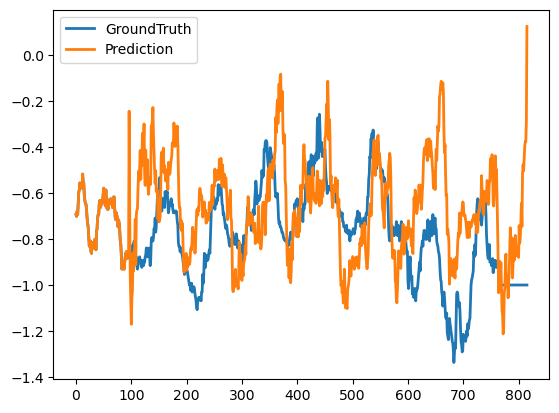

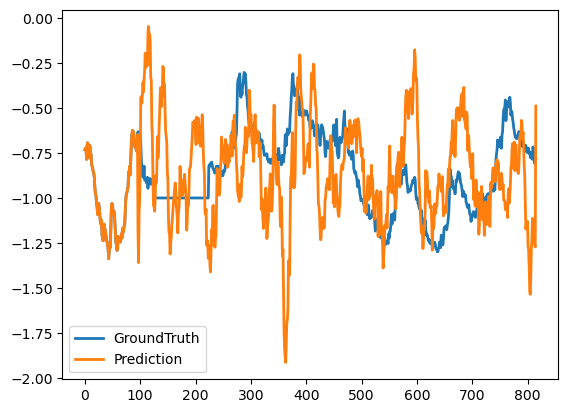

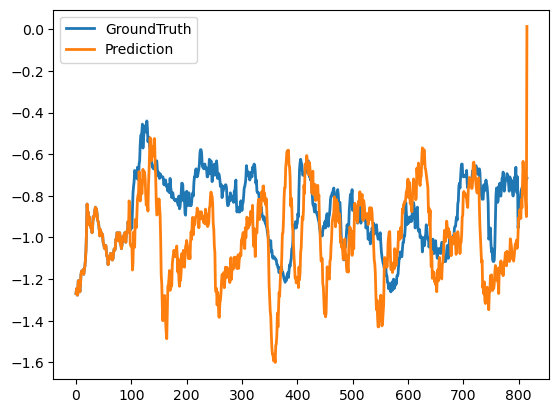

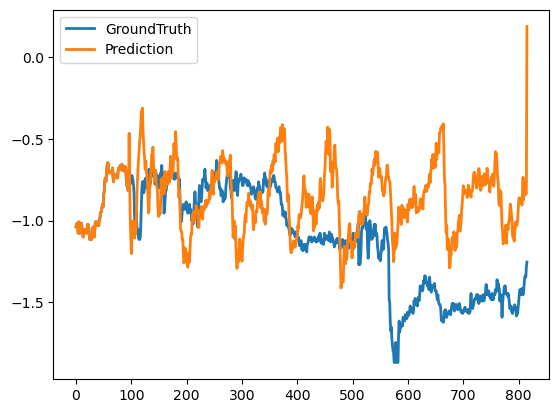

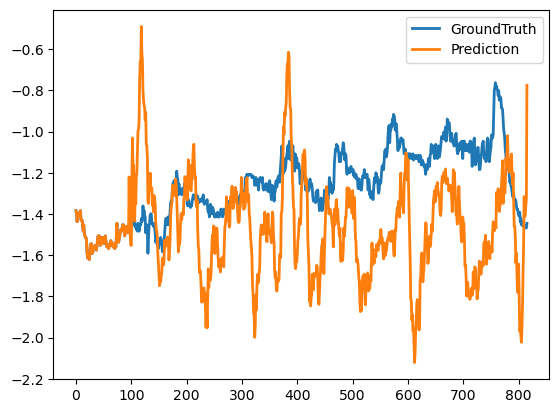

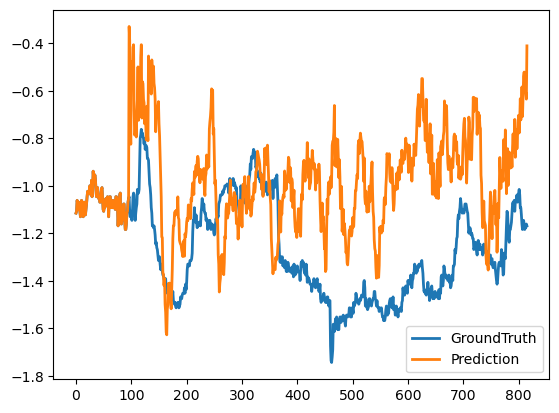

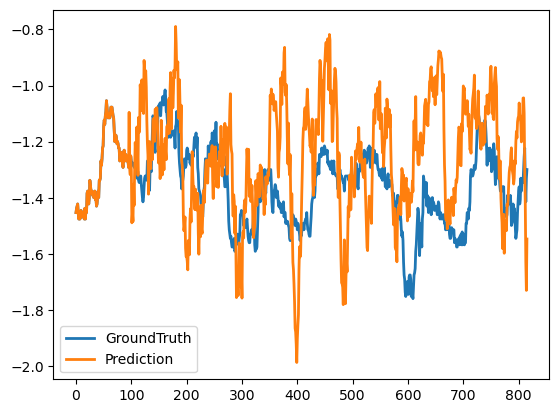

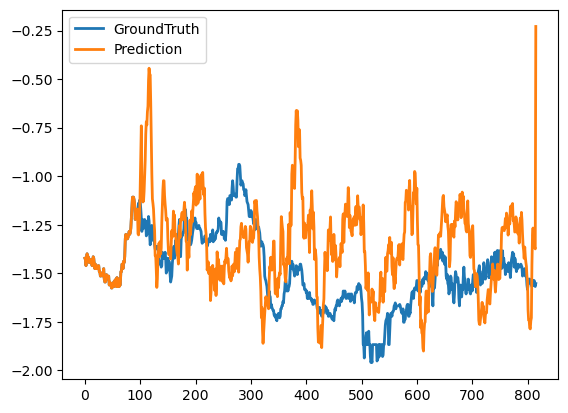

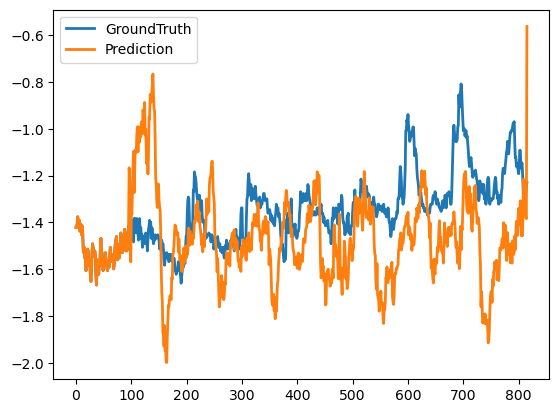

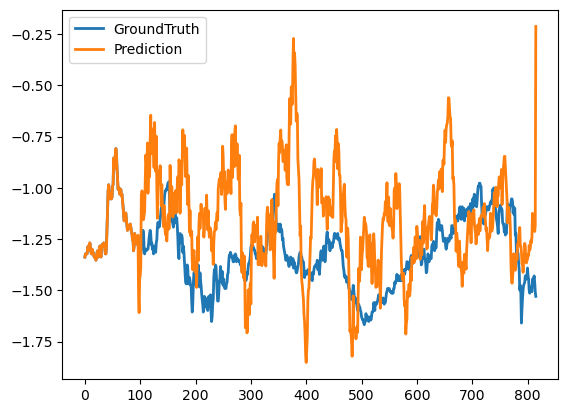

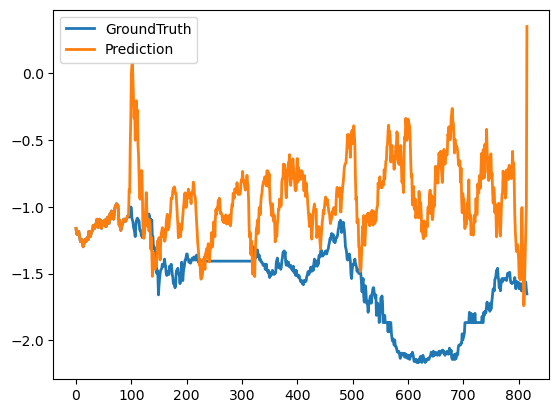

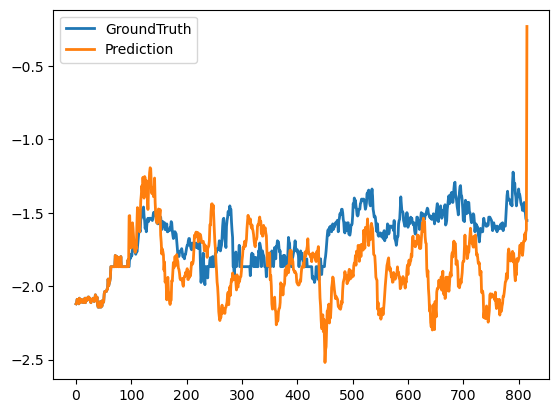

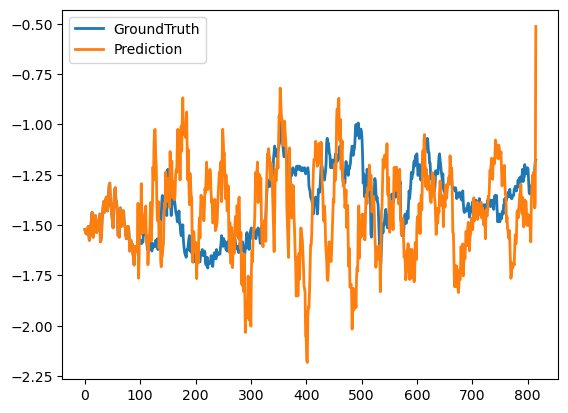

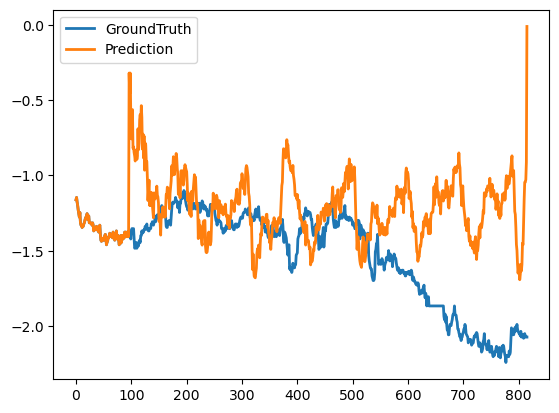

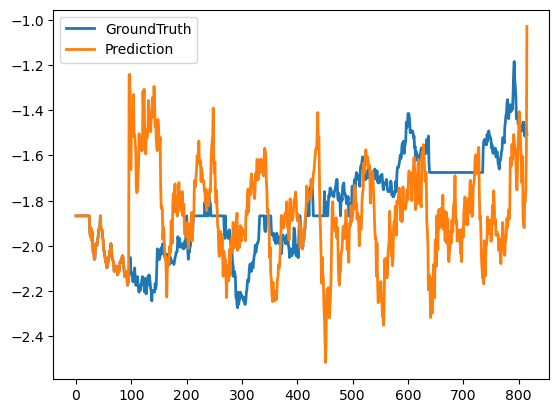

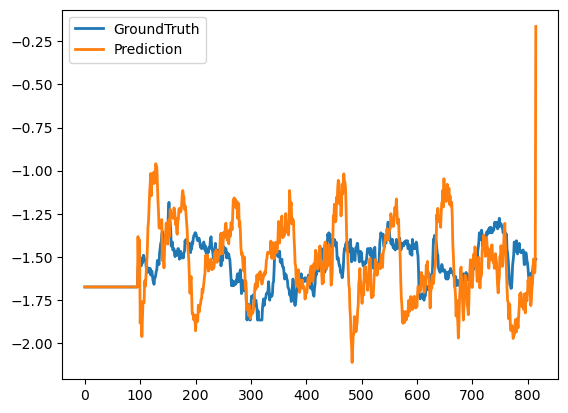

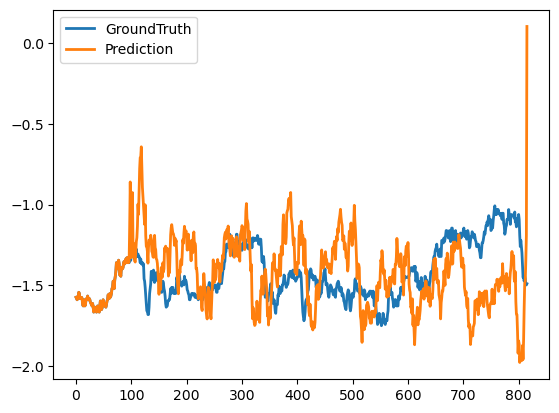

In [26]:
exp.test(setting)
torch.cuda.empty_cache()

---
# Working on ETTm2 Dataset
---

## Trail 1: FEDFormer, Dataset:ETTm2,  Metric: 96
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [27]:
args.pred_len = 96
args.data = 'ETTm2'            # dataset name
args.data_path = 'ETTm2.csv'   # data file

setting=f'{args.model}_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of FEDformer_train_on_ETTm2_96:

{'model': 'FEDformer', 'train_only': True, 'use_multi_gpu': False, 'use_gpu': True, 'learning_rate': 0.005, 'pred_len': 96, 'label_len': 48, 'seq_len': 96, 'use_amp': False, 'output_attention': False, 'features': 'M', 'checkpoints': './Checkpoints/FEDFormer_checkpoints', 'patience': 3, 'train_epochs': 6, 'data': 'ETTm2', 'root_path': './Datasets/', 'data_path': 'ETTm2.csv', 'target': 'OT', 'freq': 'h', 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'num_workers': 0, 'itr': 5, 'des': 'exp', 'gpu': 0, 'devices': '0,1,2,3', 'modes': 32, 'moving_avg': [12]}


### Training

In [28]:
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 34369
val 11425
test 11425
	iters: 100, epoch: 1 | loss: 781.2073975
	speed: 0.1029s/iter; left time: 652.8441s
	iters: 200, epoch: 1 | loss: 0.8797943
	speed: 0.1032s/iter; left time: 644.2906s
	iters: 300, epoch: 1 | loss: 0.9088013
	speed: 0.1035s/iter; left time: 636.1650s
	iters: 400, epoch: 1 | loss: 1.0076213
	speed: 0.1033s/iter; left time: 624.4874s
	iters: 500, epoch: 1 | loss: 3.6789885
	speed: 0.1032s/iter; left time: 613.3027s
	iters: 600, epoch: 1 | loss: 0.9518456
	speed: 0.1032s/iter; left time: 603.4755s
	iters: 700, epoch: 1 | loss: 1.2119082
	speed: 0.1034s/iter; left time: 594.0996s
	iters: 800, epoch: 1 | loss: 0.7706234
	speed: 0.1038s/iter; left time: 585.9595s
	iters: 900, epoch: 1 | loss: 0.6615829
	speed: 0.1035s/iter; left time: 573.6903s
	iters: 1000, epoch: 1 | loss: 0.3814854
	speed: 0.1035s/iter; left time: 563.5540s
Epoch: 1 cost time: 111.0647304058075
Epoch: 1, Steps: 1074 | Train Loss: 116.1800050 Vali Loss: 0.2025309 Test Loss: 

Model(
  (decomp): series_decomp_multi(
    (layer): Linear(in_features=1, out_features=1, bias=True)
  )
  (enc_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (dec_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
   

### Testing

test 11425
test shape: (357, 32, 96, 7) (357, 32, 96, 7)
test shape: (11424, 96, 7) (11424, 96, 7)
mse:0.21847353875637054, mae:0.30306771397590637


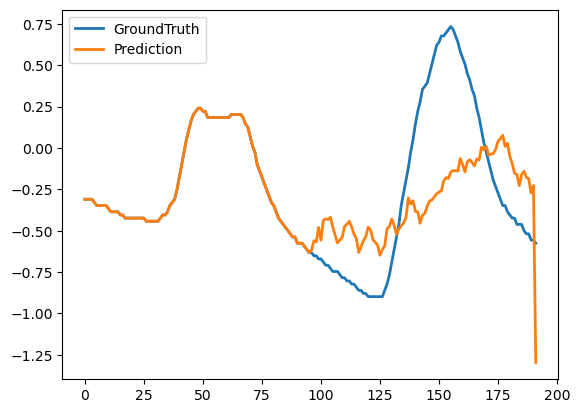

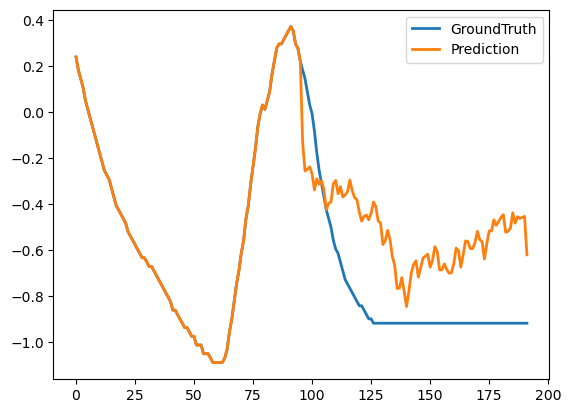

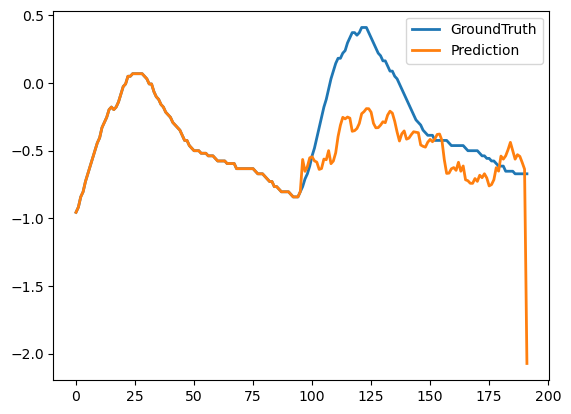

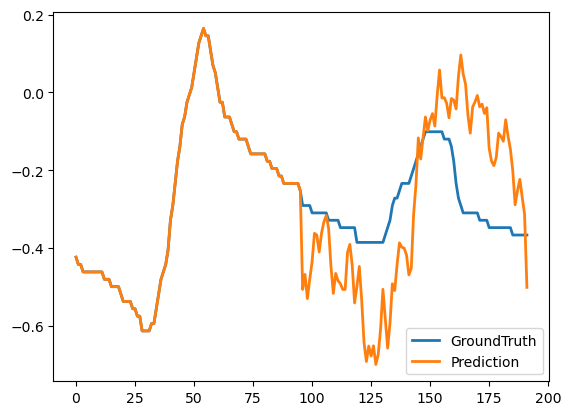

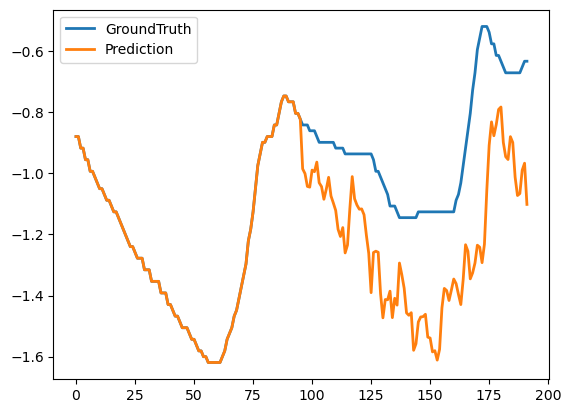

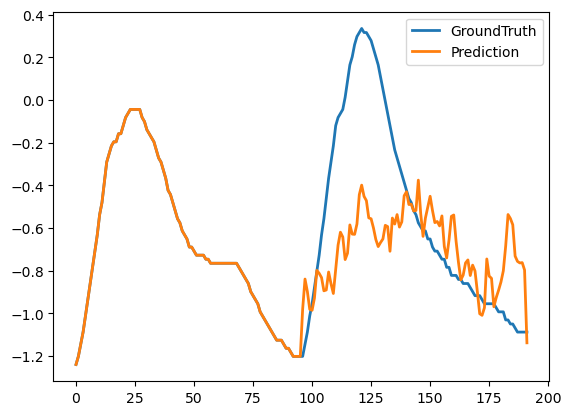

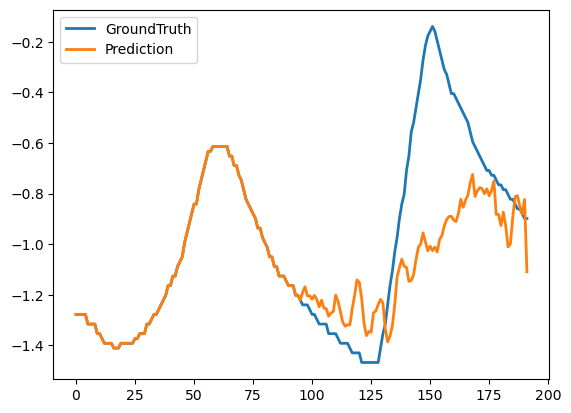

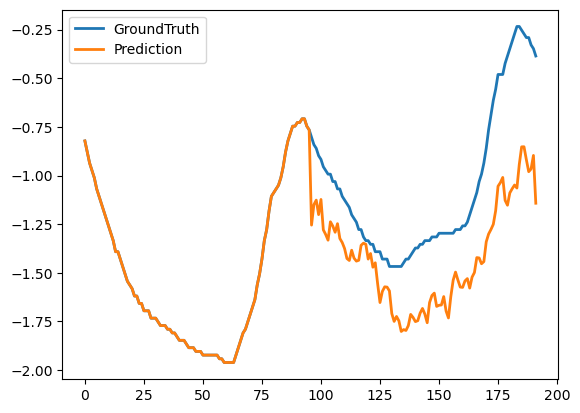

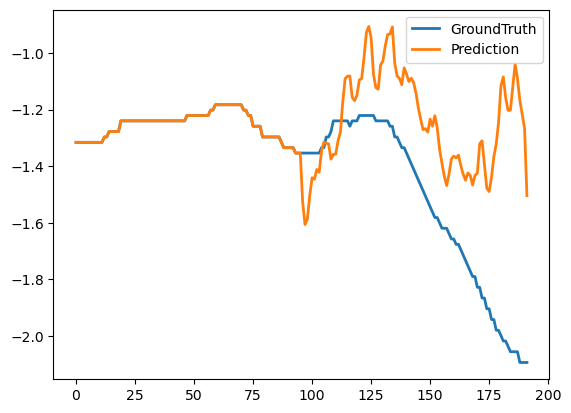

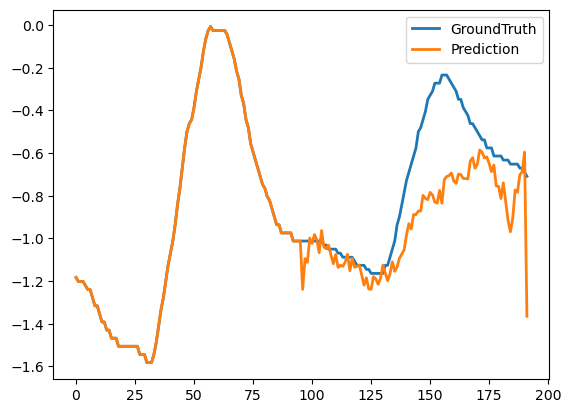

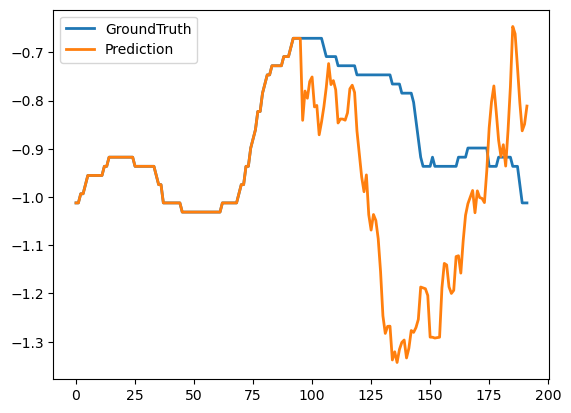

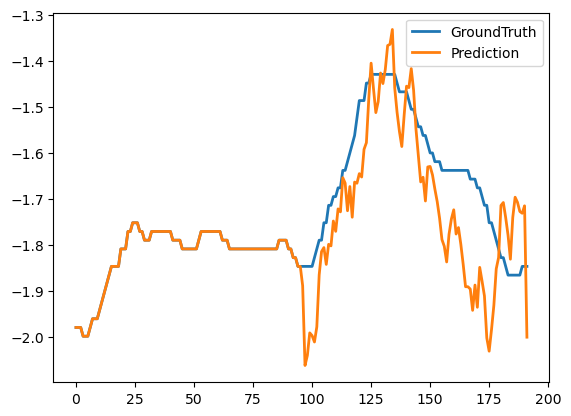

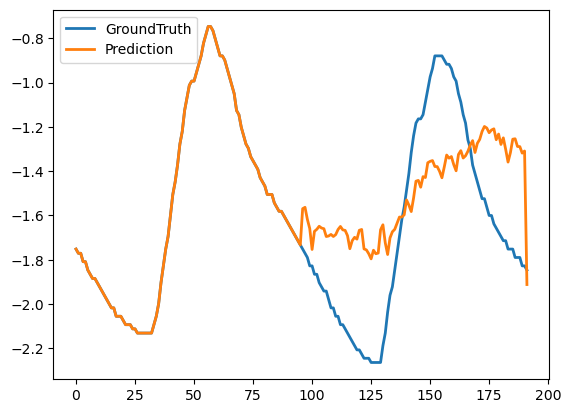

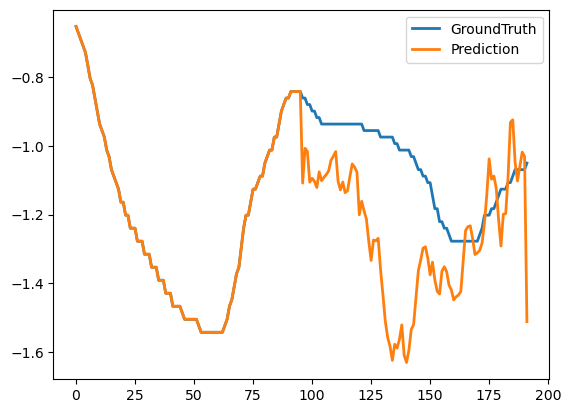

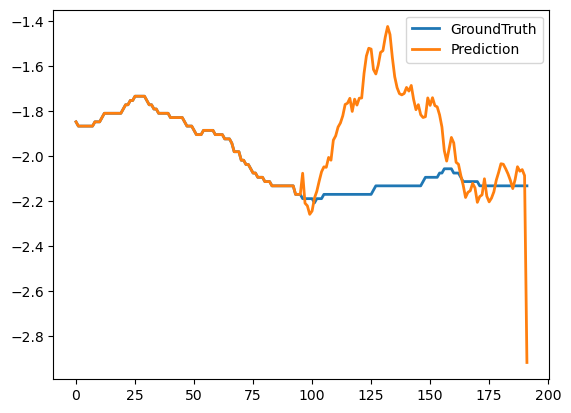

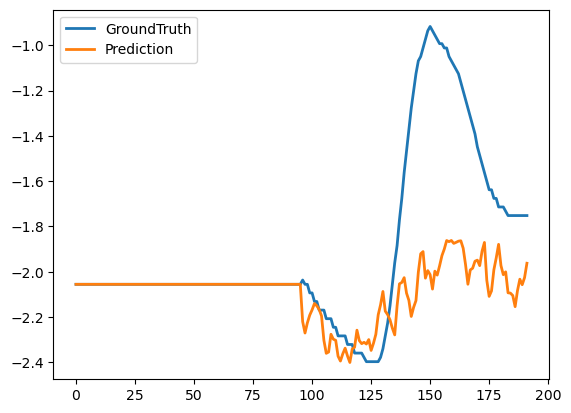

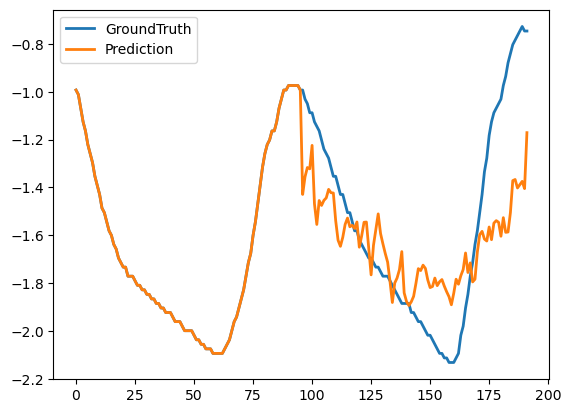

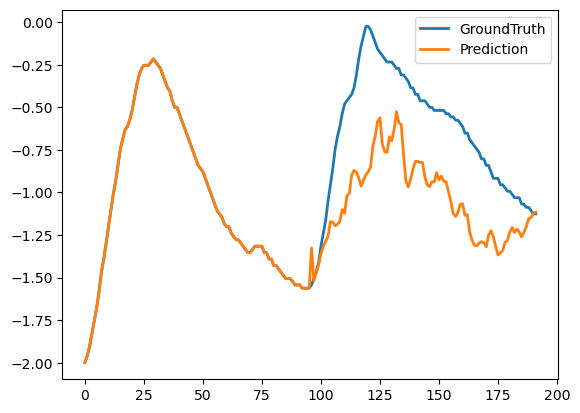

In [29]:
exp.test(setting)
torch.cuda.empty_cache()

## Trail 2: FEDFormer, Dataset:ETTm2,  Metric: 192
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [30]:
args.pred_len = 192

setting=f'{args.model}_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of FEDformer_train_on_ETTm2_192:

{'model': 'FEDformer', 'train_only': True, 'use_multi_gpu': False, 'use_gpu': True, 'learning_rate': 0.005, 'pred_len': 192, 'label_len': 48, 'seq_len': 96, 'use_amp': False, 'output_attention': False, 'features': 'M', 'checkpoints': './Checkpoints/FEDFormer_checkpoints', 'patience': 3, 'train_epochs': 6, 'data': 'ETTm2', 'root_path': './Datasets/', 'data_path': 'ETTm2.csv', 'target': 'OT', 'freq': 'h', 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'num_workers': 0, 'itr': 5, 'des': 'exp', 'gpu': 0, 'devices': '0,1,2,3', 'modes': 32, 'moving_avg': [12]}


### Training

In [31]:
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 34273
val 11329
test 11329
	iters: 100, epoch: 1 | loss: 1.0390359
	speed: 0.1253s/iter; left time: 792.7493s
	iters: 200, epoch: 1 | loss: 0.2707334
	speed: 0.1237s/iter; left time: 770.5118s
	iters: 300, epoch: 1 | loss: 0.2882882
	speed: 0.1236s/iter; left time: 757.5903s
	iters: 400, epoch: 1 | loss: 417.6005859
	speed: 0.1250s/iter; left time: 753.5489s
	iters: 500, epoch: 1 | loss: 75.6999512
	speed: 0.1259s/iter; left time: 746.2736s
	iters: 600, epoch: 1 | loss: 2.3335462
	speed: 0.1253s/iter; left time: 729.8695s
	iters: 700, epoch: 1 | loss: 2.2775528
	speed: 0.1228s/iter; left time: 703.0715s
	iters: 800, epoch: 1 | loss: 0.9203844
	speed: 0.1235s/iter; left time: 694.9691s
	iters: 900, epoch: 1 | loss: 0.5394717
	speed: 0.1233s/iter; left time: 681.3497s
	iters: 1000, epoch: 1 | loss: 0.6538749
	speed: 0.1269s/iter; left time: 688.7581s
Epoch: 1 cost time: 133.49674916267395
Epoch: 1, Steps: 1071 | Train Loss: 277.5286438 Vali Loss: 0.5699264 Test Loss

Model(
  (decomp): series_decomp_multi(
    (layer): Linear(in_features=1, out_features=1, bias=True)
  )
  (enc_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (dec_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
   

### Testing

test 11329
test shape: (354, 32, 192, 7) (354, 32, 192, 7)
test shape: (11328, 192, 7) (11328, 192, 7)
mse:0.3557473421096802, mae:0.417468786239624


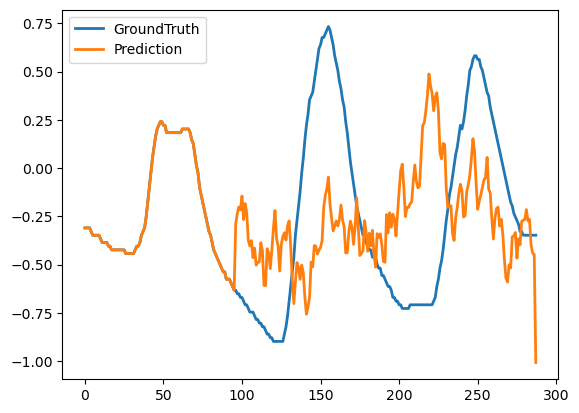

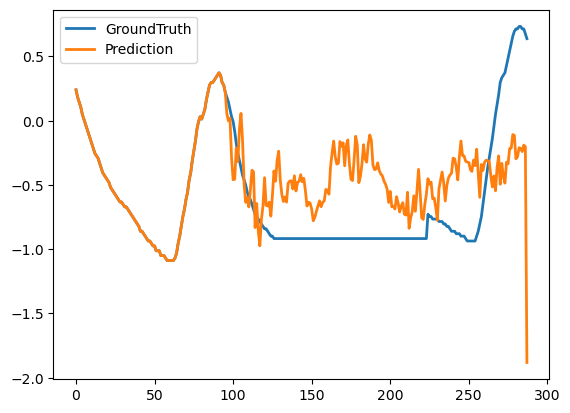

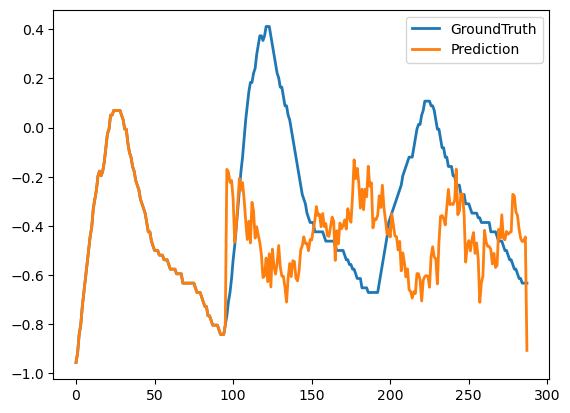

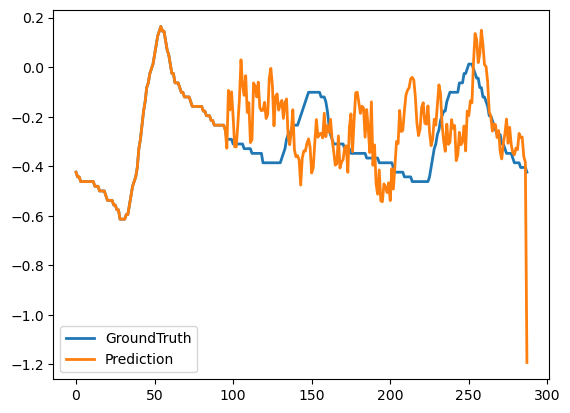

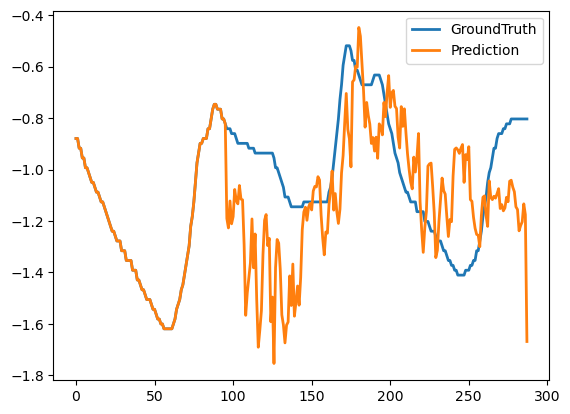

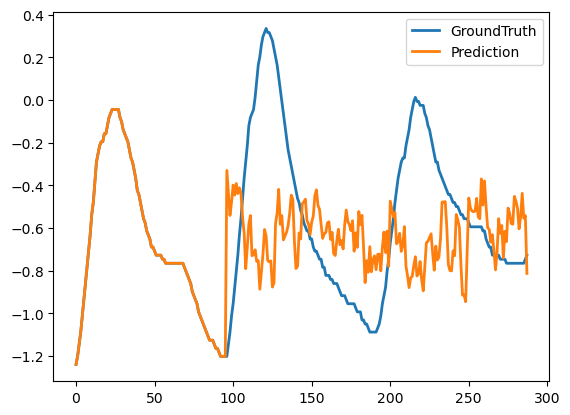

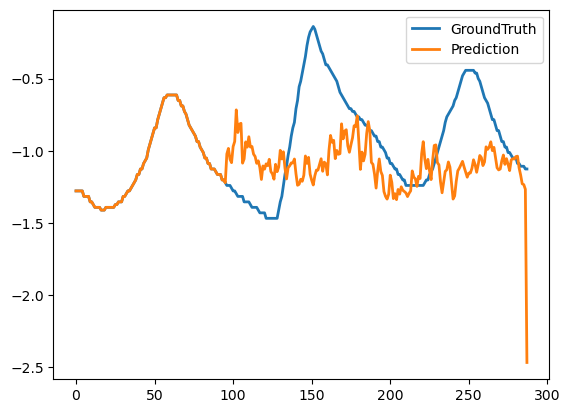

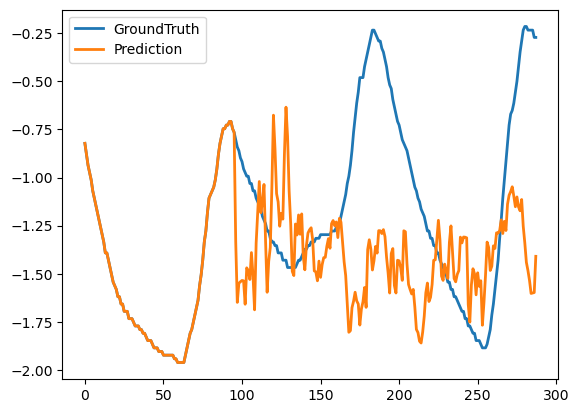

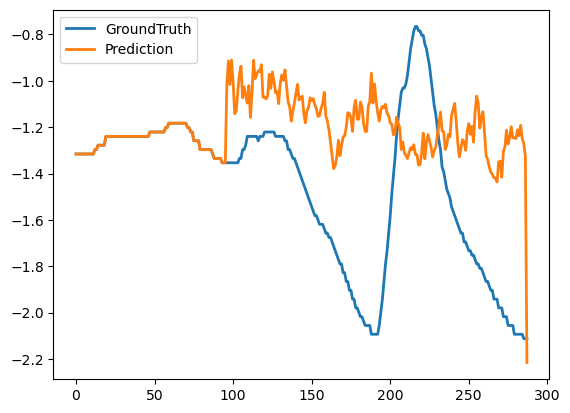

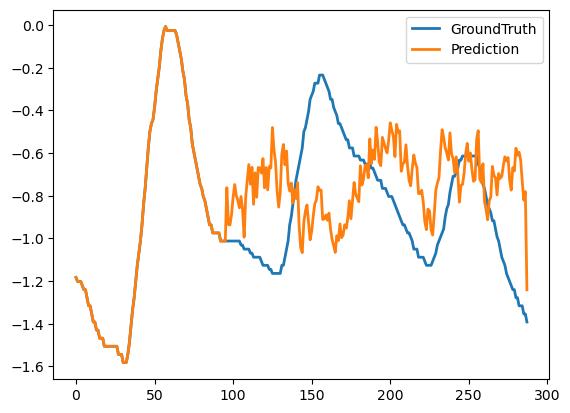

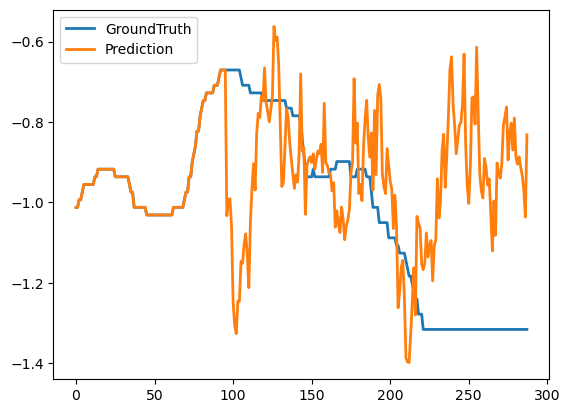

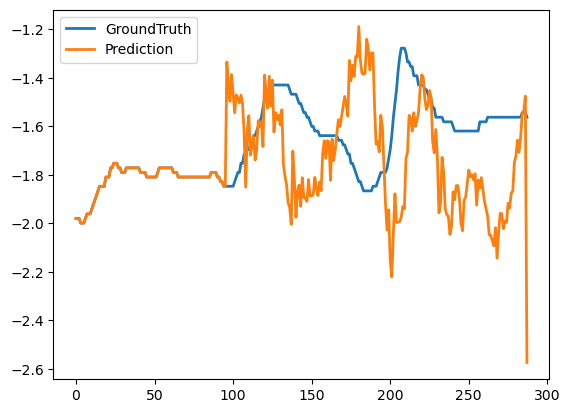

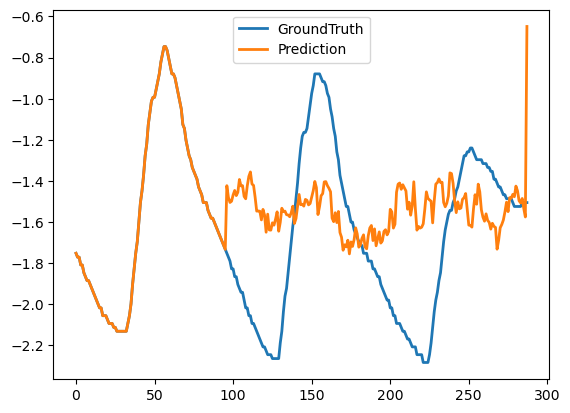

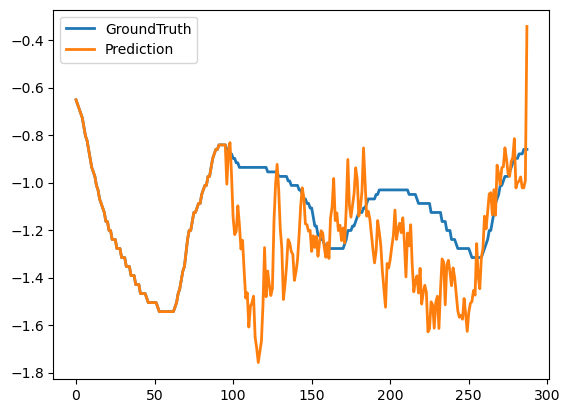

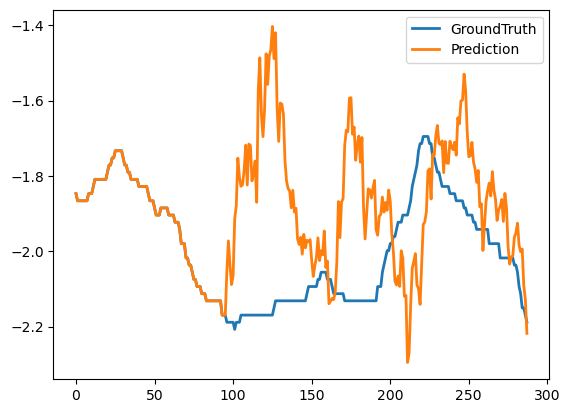

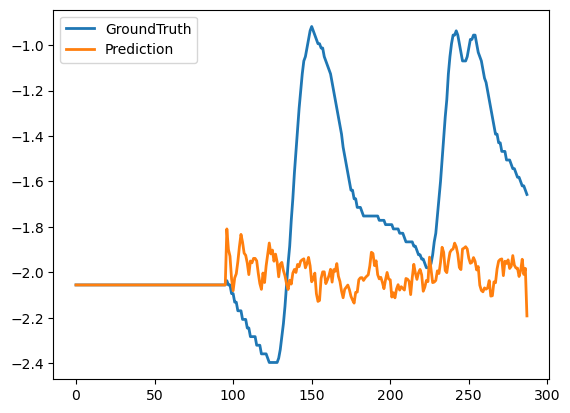

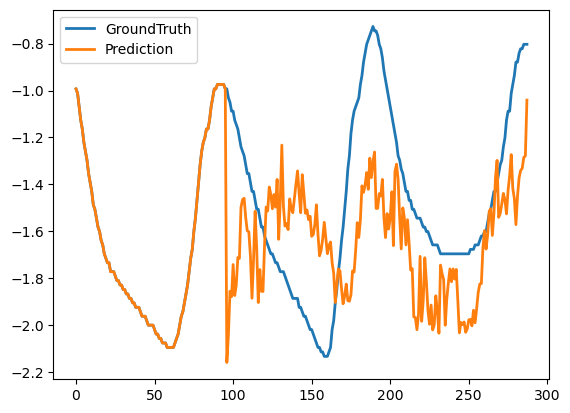

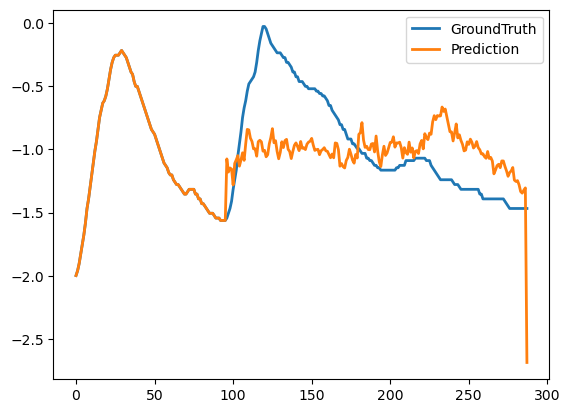

In [32]:
exp.test(setting)
torch.cuda.empty_cache()

## Trail 3: FEDFormer, Dataset:ETTm2,  Metric: 336
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [33]:
args.pred_len = 336

setting=f'{args.model}_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of FEDformer_train_on_ETTm2_336:

{'model': 'FEDformer', 'train_only': True, 'use_multi_gpu': False, 'use_gpu': True, 'learning_rate': 0.005, 'pred_len': 336, 'label_len': 48, 'seq_len': 96, 'use_amp': False, 'output_attention': False, 'features': 'M', 'checkpoints': './Checkpoints/FEDFormer_checkpoints', 'patience': 3, 'train_epochs': 6, 'data': 'ETTm2', 'root_path': './Datasets/', 'data_path': 'ETTm2.csv', 'target': 'OT', 'freq': 'h', 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'num_workers': 0, 'itr': 5, 'des': 'exp', 'gpu': 0, 'devices': '0,1,2,3', 'modes': 32, 'moving_avg': [12]}


### Training

In [34]:
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 34129
val 11185
test 11185
	iters: 100, epoch: 1 | loss: 1.1524725
	speed: 0.1522s/iter; left time: 958.2535s
	iters: 200, epoch: 1 | loss: 0.4997632
	speed: 0.1503s/iter; left time: 931.3242s
	iters: 300, epoch: 1 | loss: 986.7750854
	speed: 0.1485s/iter; left time: 905.4437s
	iters: 400, epoch: 1 | loss: 1666.5379639
	speed: 0.1506s/iter; left time: 903.0370s
	iters: 500, epoch: 1 | loss: 106.9533081
	speed: 0.1521s/iter; left time: 896.9858s
	iters: 600, epoch: 1 | loss: 97.3614578
	speed: 0.1555s/iter; left time: 901.2606s
	iters: 700, epoch: 1 | loss: 76.8196564
	speed: 0.1489s/iter; left time: 848.5479s
	iters: 800, epoch: 1 | loss: 55.1054726
	speed: 0.1530s/iter; left time: 856.5299s
	iters: 900, epoch: 1 | loss: 53.9105606
	speed: 0.1559s/iter; left time: 856.9400s
	iters: 1000, epoch: 1 | loss: 46.1054001
	speed: 0.1520s/iter; left time: 820.3520s
Epoch: 1 cost time: 162.13261032104492
Epoch: 1, Steps: 1066 | Train Loss: 14126.4034624 Vali Loss: 7.198447

Model(
  (decomp): series_decomp_multi(
    (layer): Linear(in_features=1, out_features=1, bias=True)
  )
  (enc_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (dec_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
   

### Testing

test 11185
test shape: (349, 32, 336, 7) (349, 32, 336, 7)
test shape: (11168, 336, 7) (11168, 336, 7)
mse:1.1214263439178467, mae:0.7592312097549438


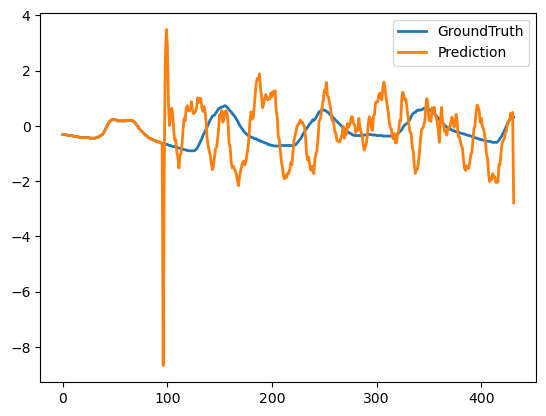

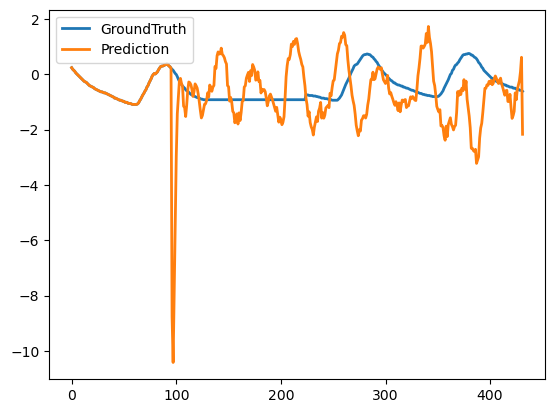

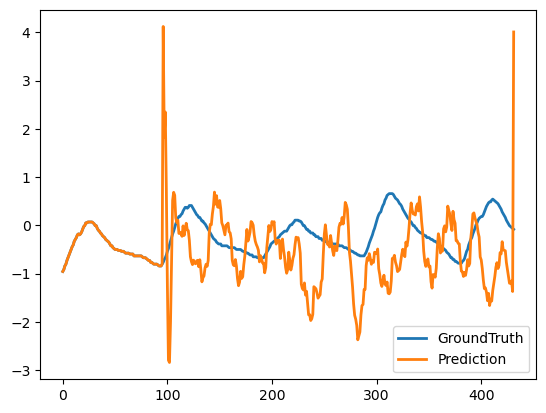

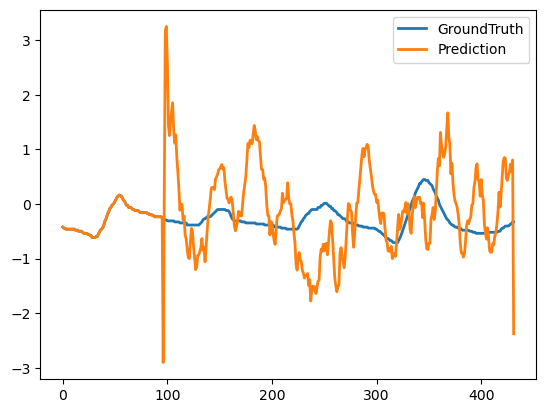

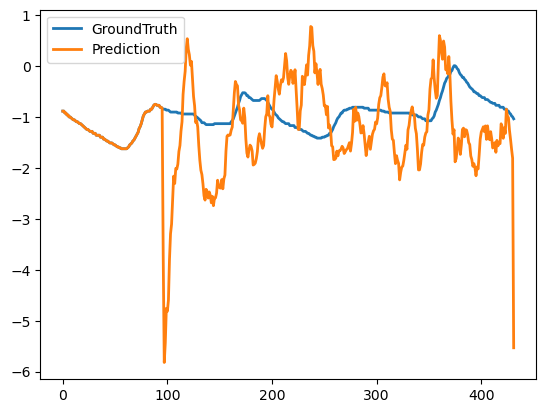

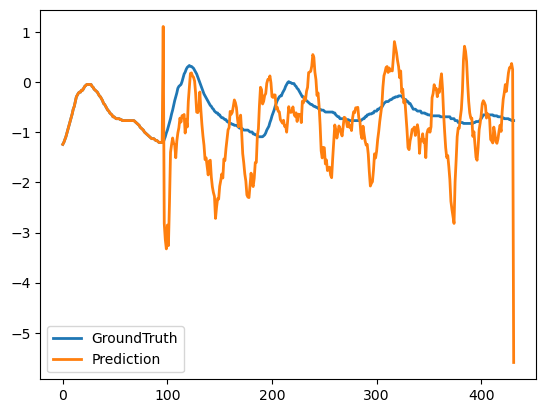

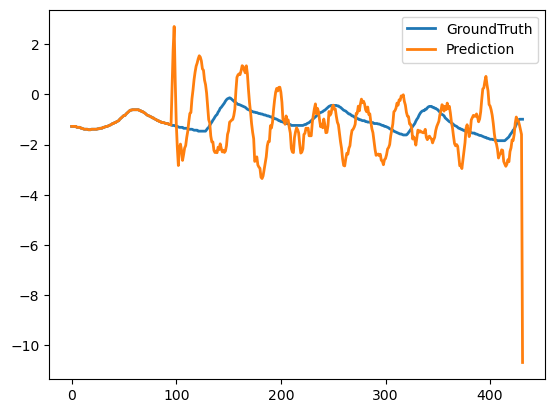

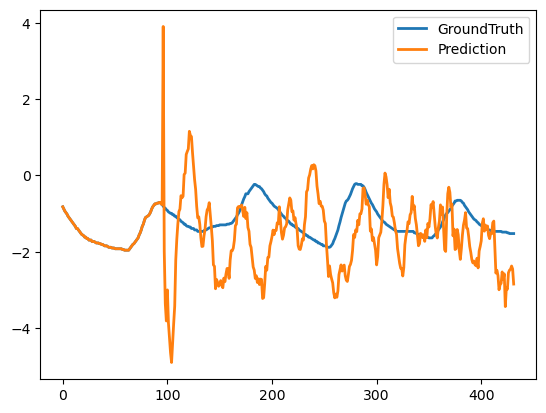

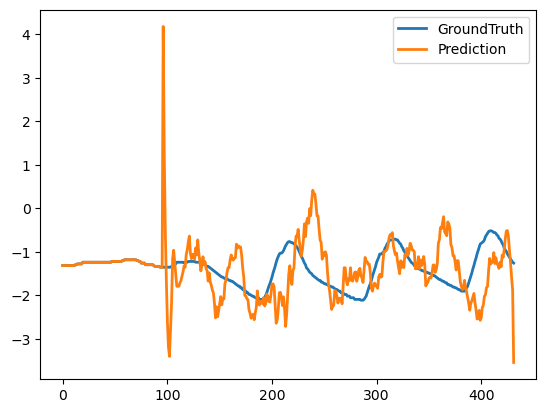

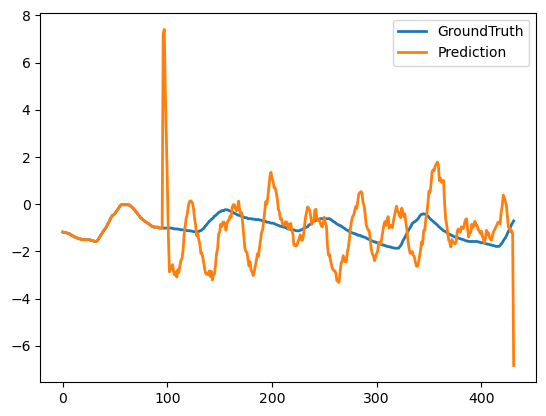

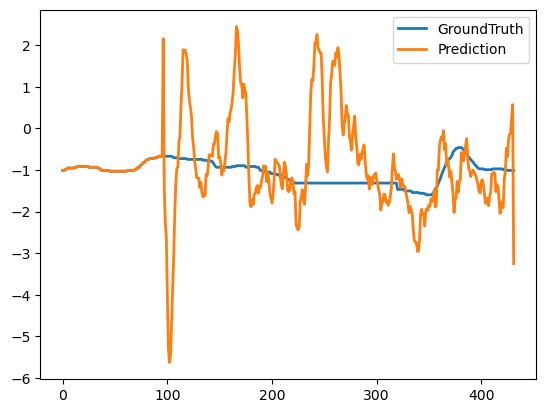

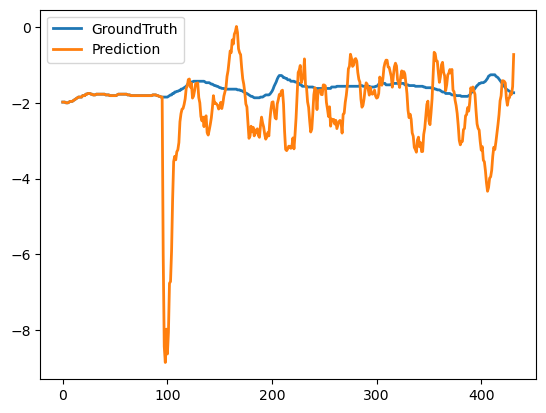

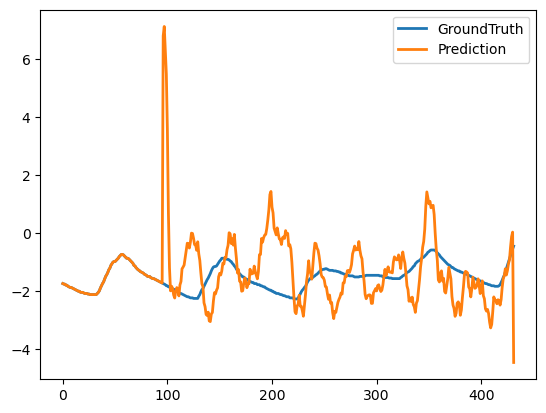

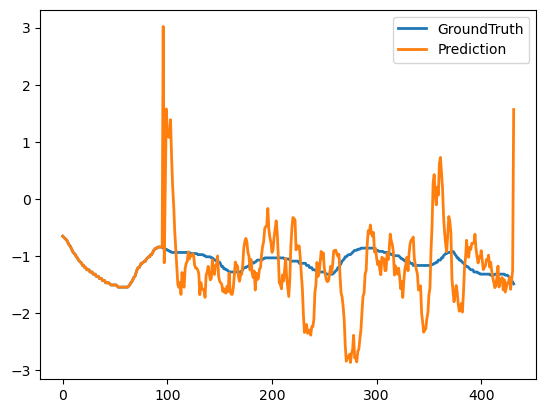

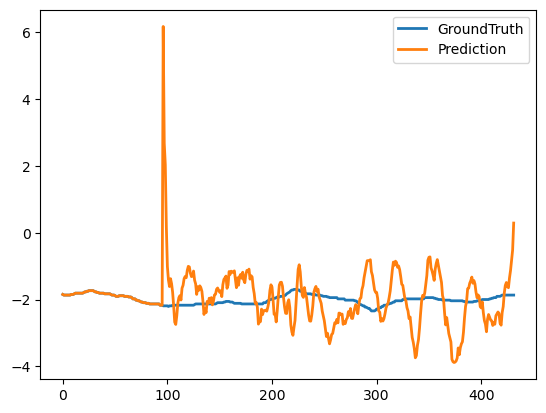

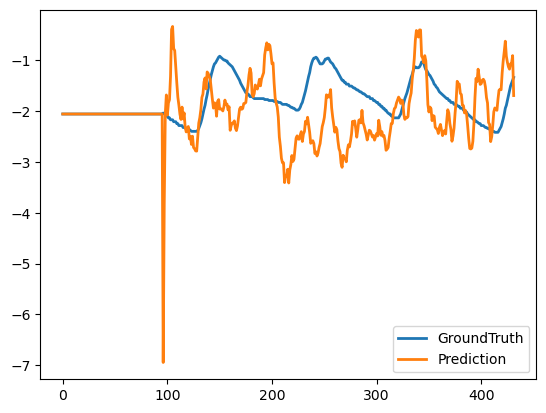

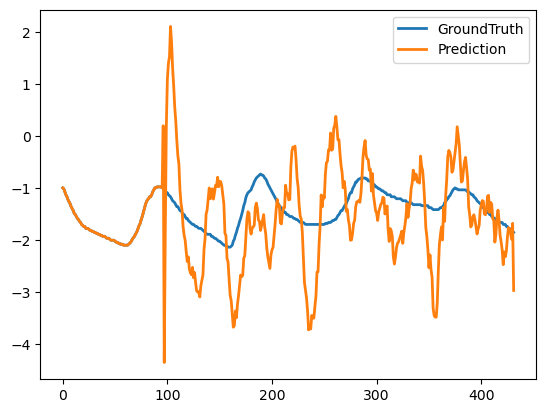

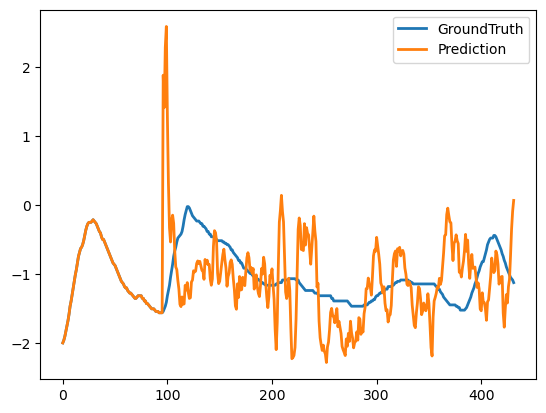

In [35]:
exp.test(setting)
torch.cuda.empty_cache()

## Trail 4: FEDFormer, Dataset:ETTm2,  Metric: 720
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [36]:
args.pred_len = 720

setting=f'{args.model}_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of FEDformer_train_on_ETTm2_720:

{'model': 'FEDformer', 'train_only': True, 'use_multi_gpu': False, 'use_gpu': True, 'learning_rate': 0.005, 'pred_len': 720, 'label_len': 48, 'seq_len': 96, 'use_amp': False, 'output_attention': False, 'features': 'M', 'checkpoints': './Checkpoints/FEDFormer_checkpoints', 'patience': 3, 'train_epochs': 6, 'data': 'ETTm2', 'root_path': './Datasets/', 'data_path': 'ETTm2.csv', 'target': 'OT', 'freq': 'h', 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'num_workers': 0, 'itr': 5, 'des': 'exp', 'gpu': 0, 'devices': '0,1,2,3', 'modes': 32, 'moving_avg': [12]}


### Training

In [37]:
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 33745
val 10801
test 10801
	iters: 100, epoch: 1 | loss: 19.7643833
	speed: 0.2159s/iter; left time: 1344.0619s
	iters: 200, epoch: 1 | loss: 0.6671243
	speed: 0.2142s/iter; left time: 1311.7059s
	iters: 300, epoch: 1 | loss: 0.5189450
	speed: 0.2135s/iter; left time: 1286.2884s
	iters: 400, epoch: 1 | loss: 0.3452266
	speed: 0.2116s/iter; left time: 1253.9336s
	iters: 500, epoch: 1 | loss: 0.5583788
	speed: 0.2218s/iter; left time: 1292.1566s
	iters: 600, epoch: 1 | loss: 1.4938104
	speed: 0.2209s/iter; left time: 1264.5662s
	iters: 700, epoch: 1 | loss: 0.6991161
	speed: 0.2193s/iter; left time: 1233.5285s
	iters: 800, epoch: 1 | loss: 0.5632223
	speed: 0.2201s/iter; left time: 1216.2381s
	iters: 900, epoch: 1 | loss: 0.5387813
	speed: 0.2212s/iter; left time: 1200.1154s
	iters: 1000, epoch: 1 | loss: 0.5555788
	speed: 0.2163s/iter; left time: 1151.6994s
Epoch: 1 cost time: 229.1407778263092
Epoch: 1, Steps: 1054 | Train Loss: 5.9287587 Vali Loss: 0.3011875 Test

Model(
  (decomp): series_decomp_multi(
    (layer): Linear(in_features=1, out_features=1, bias=True)
  )
  (enc_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (dec_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
   

### Testing

test 10801
test shape: (337, 32, 720, 7) (337, 32, 720, 7)
test shape: (10784, 720, 7) (10784, 720, 7)
mse:0.4224543869495392, mae:0.4191317856311798


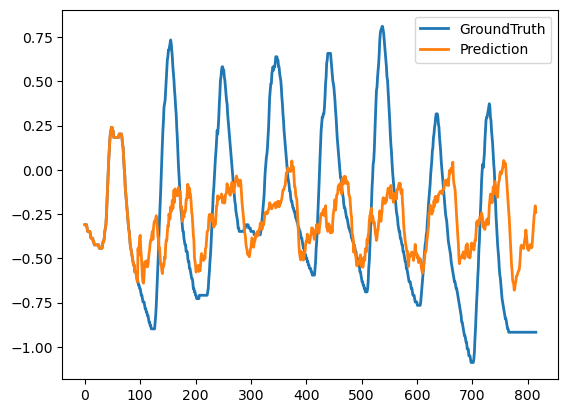

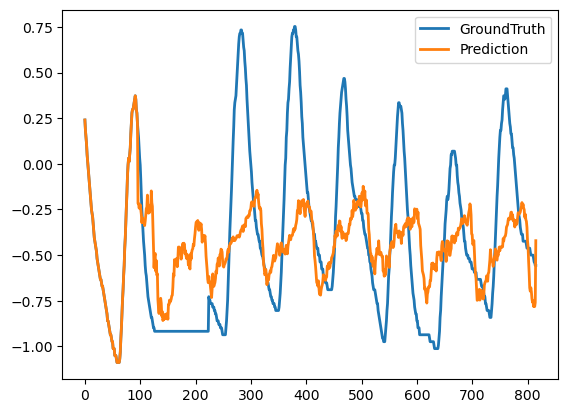

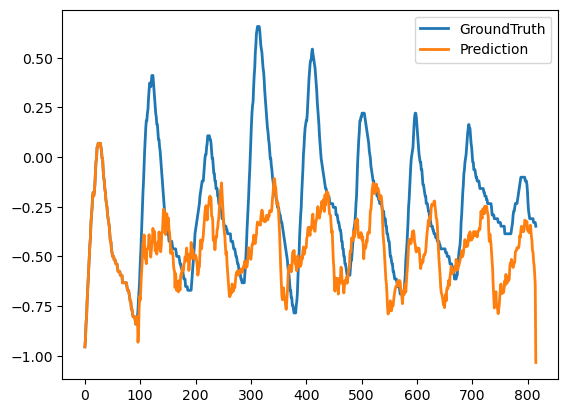

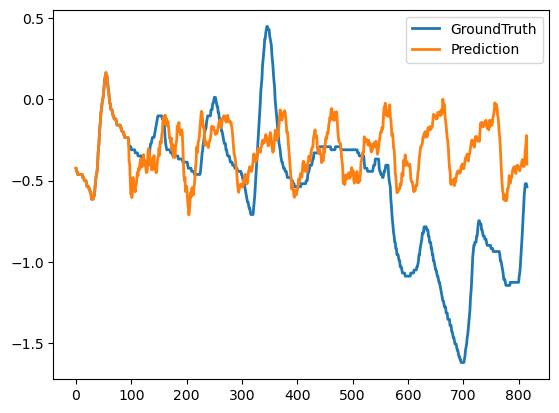

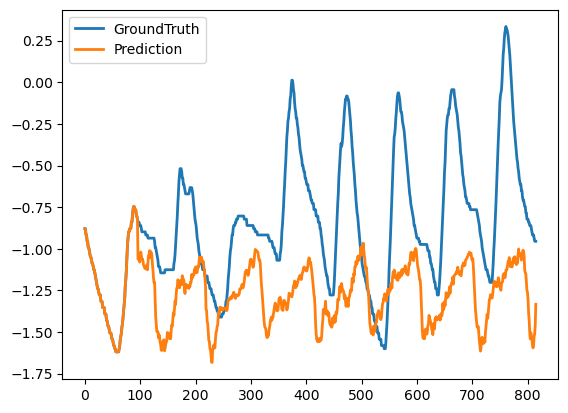

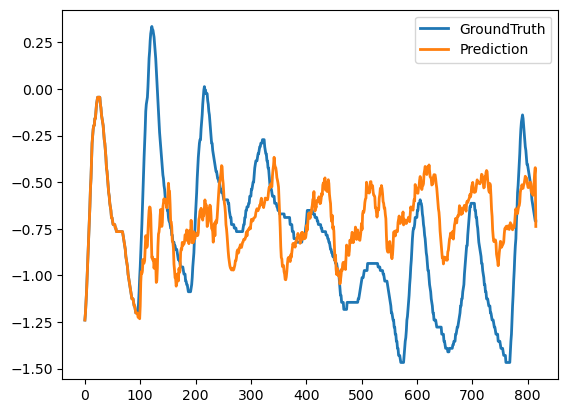

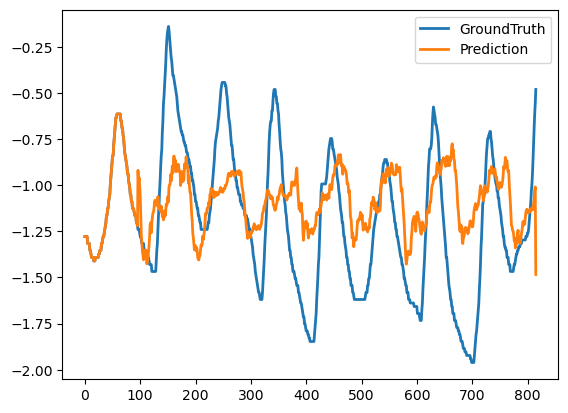

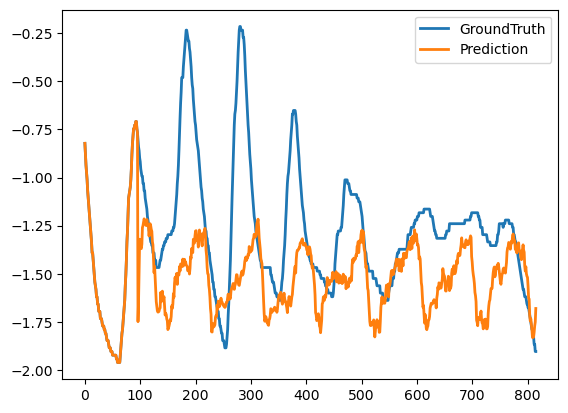

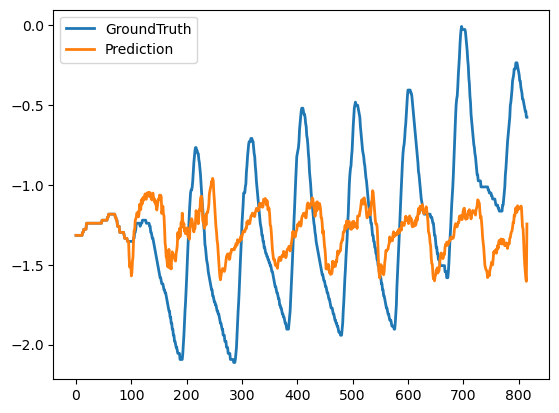

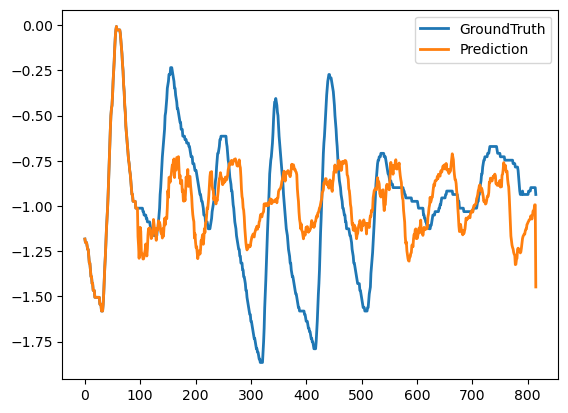

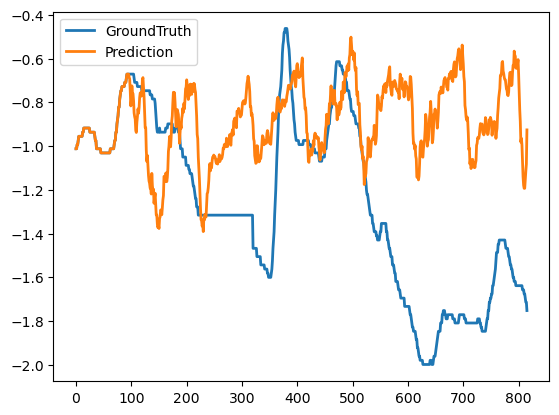

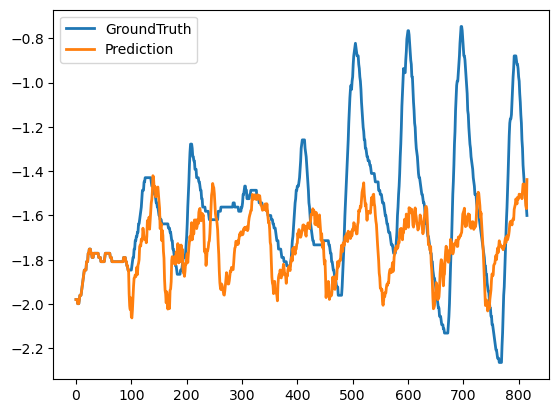

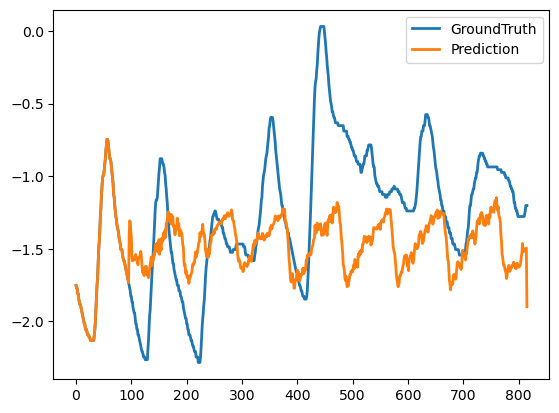

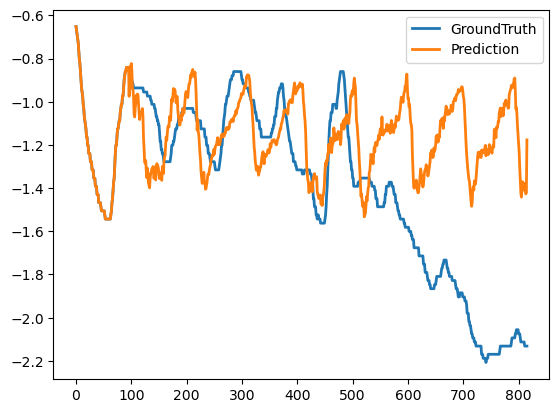

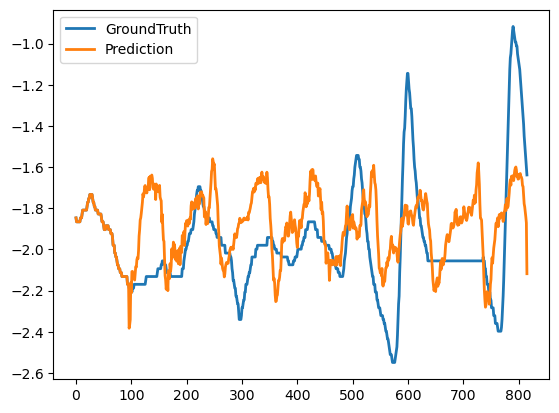

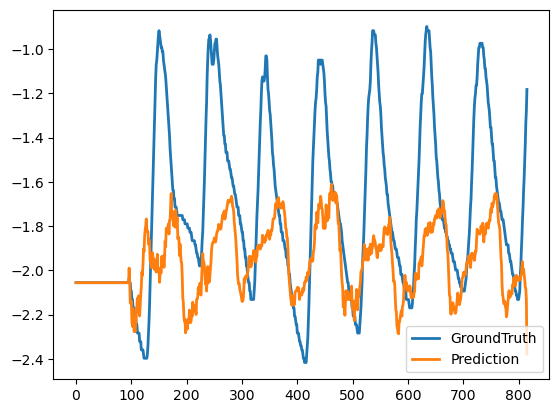

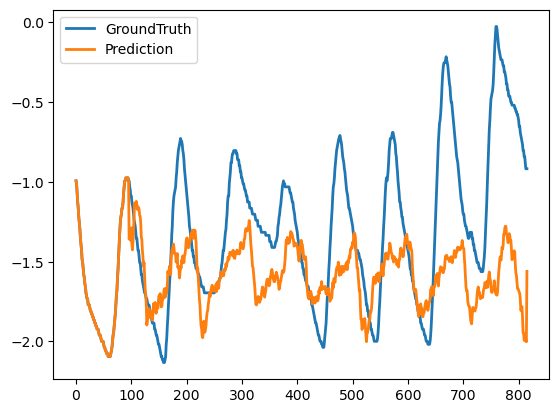

In [38]:
exp.test(setting)
torch.cuda.empty_cache()